# Sertaç Özker - ING Datathon 2018 çözümü

## 1. Verinin alınması

Kullanılması planlanan kütüphaneler bu aşamada yüklenip, gönderilen veri "df" adıyla alınıyor.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
%matplotlib inline

df = pd.read_csv('INGDatathonData2018 - yedek.csv', sep=';')

df.shape

(37224, 682)

## 2. Verinin incelenmesi

Excel ile yapılan ilk incelemede veride herhangi bir categorical değişken bulunmadığı görülmüştür. Tamamen sayılardan oluşan verinin içerisinde büyük miktarda boşluk olduğu görülüyor. Boşlukları görselleştirmek için aşağıdaki kodu kullanıyorum.

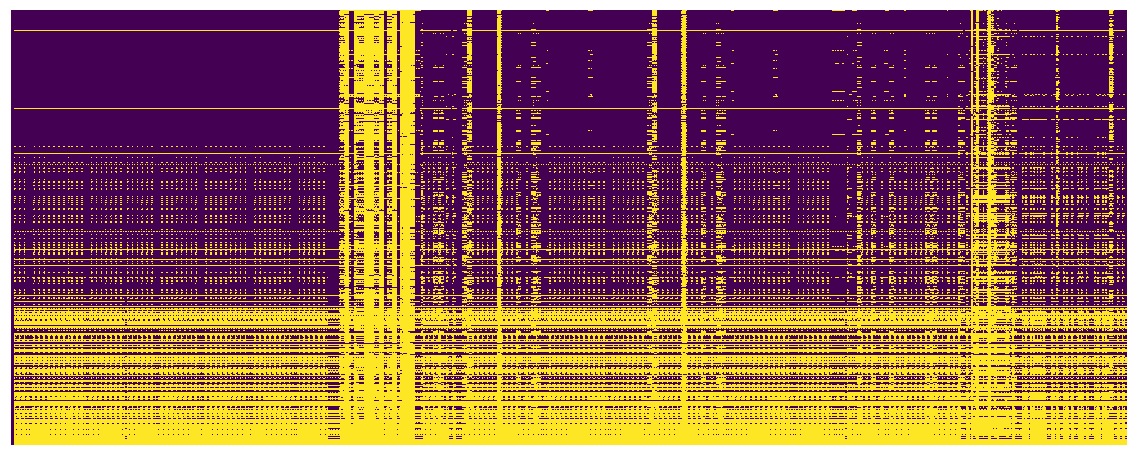

In [2]:
fig = plt.figure(figsize=(20,8))
sns.heatmap(df.isnull(),yticklabels=False,xticklabels=False,cbar=False,cmap='viridis')

Verinin alt kısmında bazı satırlarda hemen hemen hiç bilgi olmadığı görülüyor. Bazı sütunların da büyük oranda boş olduğu görülüyor. 

Satır bazında ne kadar verinin olduğunu görmek için "dolu_alan" sütununu oluşturup bunun distplot'una bakıyorum.

(0, 690)

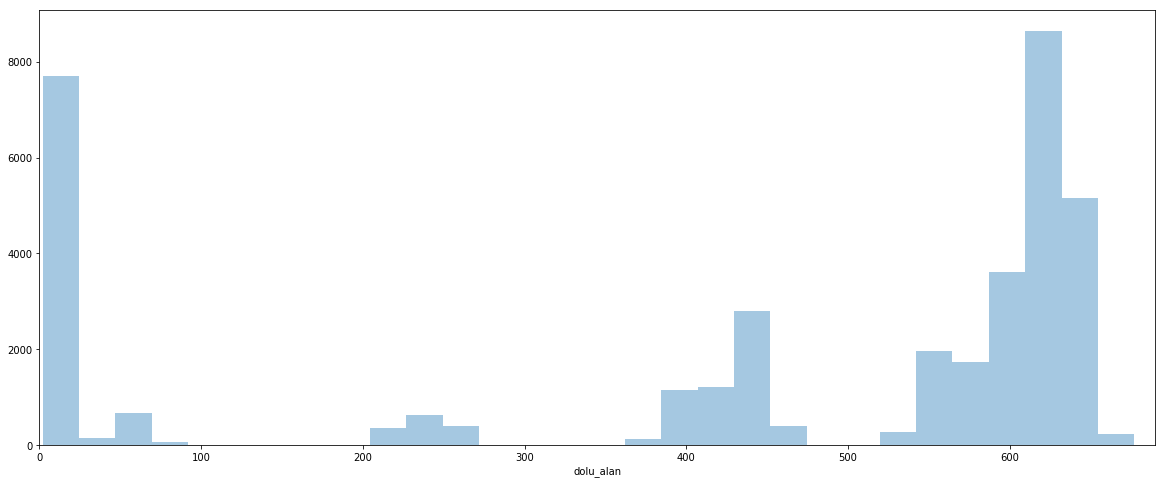

In [3]:
df['dolu_alan'] = df.count(axis=1)

fig = plt.figure(figsize=(20,8))
sns.distplot(df['dolu_alan'], kde=False)
plt.xlim(0, 690)

Bu grafiğe göre dolu alan miktarına göre verimiz 4 gruba bölünüyor gibi duruyor. Bu bölümler arasında default'a düşme oranlarını incelersek:

In [4]:
adet = df[df['dolu_alan']>=500]['PRIMARY_KEY'].count()
default_adet = df[(df['dolu_alan']>=500) & (df['DEFAULT_FLAG']==1)]['PRIMARY_KEY'].count()
oran = default_adet / adet
print("Grup 500+: adet=" + str(adet) + " - default_adet=" + str(default_adet) + " - default_oran=" + str(oran))

adet = df[(df['dolu_alan']>=300) & (df['dolu_alan']<500)]['PRIMARY_KEY'].count()
default_adet = df[(df['dolu_alan']>=300) & (df['dolu_alan']<500) & (df['DEFAULT_FLAG']==1)]['PRIMARY_KEY'].count()
oran = default_adet / adet
print("Grup 300-500: adet=" + str(adet) + " - default_adet=" + str(default_adet) + " - default_oran=" + str(oran))

adet = df[(df['dolu_alan']>=150) & (df['dolu_alan']<300)]['PRIMARY_KEY'].count()
default_adet = df[(df['dolu_alan']>=150) & (df['dolu_alan']<300) & (df['DEFAULT_FLAG']==1)]['PRIMARY_KEY'].count()
oran = default_adet / adet
print("Grup 150-300: adet=" + str(adet) + " - default_adet=" + str(default_adet) + " - default_oran=" + str(oran))

adet = df[df['dolu_alan']<150]['PRIMARY_KEY'].count()
default_adet = df[(df['dolu_alan']<150) & (df['DEFAULT_FLAG']==1)]['PRIMARY_KEY'].count()
oran = default_adet / adet
print("Grup 150-: adet=" + str(adet) + " - default_adet=" + str(default_adet) + " - default_oran=" + str(oran))

Grup 500+: adet=21593 - default_adet=726 - default_oran=0.033622007131940905
Grup 300-500: adet=5684 - default_adet=355 - default_oran=0.062456016889514424
Grup 150-300: adet=1383 - default_adet=106 - default_oran=0.07664497469269703
Grup 150-: adet=8564 - default_adet=548 - default_oran=0.0639887902849136


Verinin çoğunluğunda 500'den fazla bilgi bulunuyor. Ancak 500'den az bilgi bulunan satırların default'a düşme oranı, diğerinin 2 katı gibi duruyor. Bu durumda "dolu_alan" bilgisini saklamak mantıklı olacaktır.

Bunun dışında eldeki verilerle sağlıklı bir değerlendirme yapılabilmesi için müşterinin elimizde en azından 3 aylık ortalama bakiyesinin olması gerektiğini düşünüyorum. Bu en temel bilgisi olmayan müşteriler için default ihtimali hesaplamasını gereksiz bulduğum için 3 aylık toplam risk kolonu olmayan satırları silme kararı aldım. Yapılan değişiklik 100'den az sütunu dolu olan satırları da silecektir.

(28660, 683)


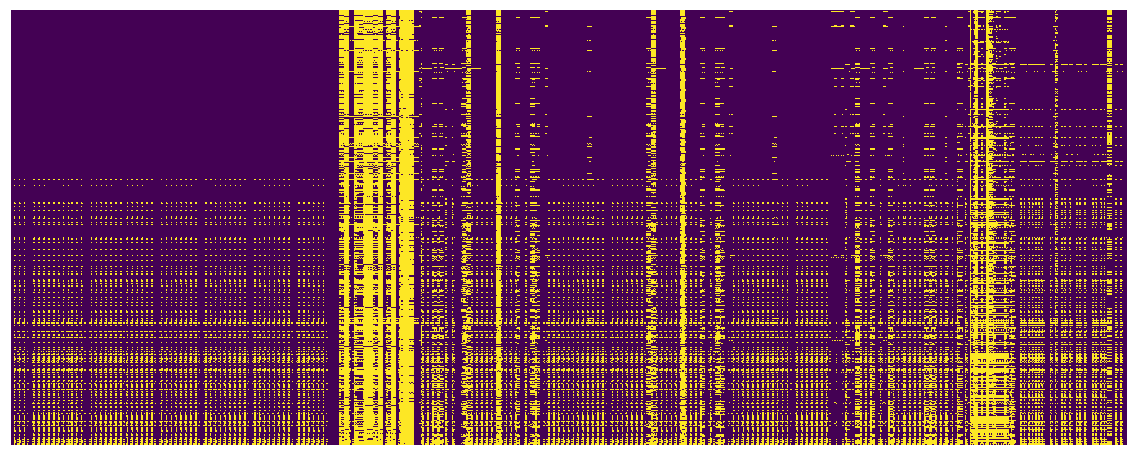

In [5]:
df = df[df['AVG_TTL_RSK3']>=0]
print(df.shape)

fig = plt.figure(figsize=(20,8))
sns.heatmap(df.isnull(),yticklabels=False,xticklabels=False,cbar=False,cmap='viridis')

### Korelasyonlar

Elimizdeki veri kümesinin DEFAULT_FLAG ile korelasyonunu hesaplayıp, en yüksek korelasyon içeren sütunları görelim. DEFAULT_FLAG sadece 0 ve 1'den oluştuğu için korelasyon hesaplamak aslında çok anlamlı değil. Ancak bir sonraki aşamada yapacağım Polynomial Features'ın sonuçlarını karşılaştırmak için bu hesaplamayı da yapmak durumundayım.

In [6]:
korelasyonlar = pd.DataFrame(columns=['sutun','deger','adet'])
columns = df.columns

for col in columns:
    #korelasyon hesaplamasi
    kor = df['DEFAULT_FLAG'].corr(df[col])
    adet = df[col].count()
    
    korelasyon_ekleme = pd.DataFrame({'sutun':[col], 'deger':[kor], 'adet':[adet]})
    korelasyonlar = pd.concat([korelasyonlar,korelasyon_ekleme])


korelasyonlar['abs_deger'] = abs(korelasyonlar['deger'])
korelasyonlar['adet'] = korelasyonlar.adet.astype(float)
korelasyonlar.sort_values(by='abs_deger', inplace=True, ascending=False)
korelasyonlar.head(10)

,adet,deger,sutun,abs_deger
0,28660.0,1.000000,DEFAULT_FLAG,1.000000
0,23.0,0.173705,STDDEV_FX_OR_FX_NON_UTIL12,0.173705
0,23.0,-0.126245,STDDEV_TTL_FX_NON_CASH_RSK12,0.126245
0,139.0,0.123206,STDDEV_TTL_ACCRD_INT_AMT12,0.123206
0,20227.0,0.107942,STD_NUMBER_OF_BANK_12,0.107942
0,27227.0,0.095958,AVG_CASH_LIMIT_TL_UTIL6,0.095958
0,28593.0,0.095685,MAX_CASH_LIMIT_TL_UTIL3,0.095685
0,28593.0,0.095509,AVG_CASH_LIMIT_TL_UTIL3,0.095509
0,28594.0,0.092774,MAX_CASH_LIMIT_UTIL3,0.092774
0,28594.0,0.092650,AVG_CASH_LIMIT_UTIL3,0.092650


Görülebileceği üzere korelasyonu yüksek olan alanlar genelde çok dolu olmayan sütunlardan geliyor. Bu sütunların genele göre etkisi zayıf olacaktır. Arkasından gelenler ise beklediğim üzere nakit limit kullanım oranlarına dair alanlar. Risk büyümesi ya da limit kullanım oranı büyümelerinin de buraya gelmesini beklerdim.

### Polynomial Features

Eldeki verilerden ciddi bir korelasyon yakalayamadığım inancındayım. Belki sütunlar arasındaki ilişkilerden benim göremediğim bir durum çıkabilir. Bu sebeple SKLearn kütüphanesinin Polynomial Features özelliğini kullanacağım.

In [7]:
poly_girecek_sutunlar = korelasyonlar[korelasyonlar['sutun']!='DEFAULT_FLAG']['sutun'].head(26).tolist()

poly = df[poly_girecek_sutunlar]
poly_flag = df['DEFAULT_FLAG']

#Boşlukları median değer ile dolduruyorum
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')
poly = imputer.fit_transform(poly)

from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree = 2)
poly_transformer.fit(poly)
poly = poly_transformer.transform(poly)

sutun_isimleri = poly_transformer.get_feature_names(input_features = poly_girecek_sutunlar)

poly = pd.DataFrame(poly, columns=sutun_isimleri)

poly['DEFAULT_FLAG'] = poly_flag

#korelasyon hesaplaması
korelasyonlar_pf = pd.DataFrame(columns=['sutun','deger','adet'])
columns = poly.columns

for col in columns:
    #korelasyon hesaplamasi
    kor = poly['DEFAULT_FLAG'].corr(poly[col])
    adet = poly[col].count()
    
    korelasyon_ekleme = pd.DataFrame({'sutun':[col], 'deger':[kor], 'adet':[adet]})
    korelasyonlar_pf = pd.concat([korelasyonlar_pf,korelasyon_ekleme])


korelasyonlar_pf['abs_deger'] = abs(korelasyonlar_pf['deger'])
korelasyonlar_pf['adet'] = korelasyonlar_pf.adet.astype(float)
korelasyonlar_pf.sort_values(by='abs_deger', inplace=True, ascending=False)
korelasyonlar_pf.head(10)

,adet,deger,sutun,abs_deger
0,26316.0,1.000000,DEFAULT_FLAG,1.000000
0,28660.0,0.015416,AVG_CASH_LIMIT_UTIL6,0.015416
0,28660.0,-0.015221,MAX_NUMBER_OF_BANK12^2,0.015221
0,28660.0,0.015207,STDDEV_FX_OR_FX_NON_UTIL12 AVG_CASH_LIMIT_UTIL6,0.015207
0,28660.0,0.014390,MIN_CASH_LIMIT_UTIL6,0.014390
0,28660.0,0.014294,MAX_CASH_LIMIT_UTIL6,0.014294
0,28660.0,0.014205,STDDEV_FX_OR_FX_NON_UTIL12 MIN_CASH_LIMIT_UTIL6,0.014205
0,28660.0,0.014119,MIN_CASH_LIMIT_UTIL3,0.014119
0,28660.0,0.014102,STDDEV_FX_OR_FX_NON_UTIL12 MAX_CASH_LIMIT_UTIL6,0.014102
0,28660.0,0.013986,AVG_CASH_LIMIT_UTIL3,0.013986


Polynomial Features sonucu başarılı olmadı. Hatta impute ettiğimiz değerler korelasyonların daha da düşmesine sebep oldu. Modeli kurarken PF kullanmayacağım gibi, boş sütunları da impute etmeme kararı aldım.

## 3. Veri üstünde değişiklikler yapılması

Veride çok fazla DT_MAX ve DT_MIN şeklinde tarihler bulunuyor. Bunların bu şekilde kullanılmasınun uygun olmadığını düşünüyorum. MAX ve MIN tarihler arasındaki farkı alıp bunu _FR adlı bir sütununa yazacak fonksiyon yazacağım. Ayrıca MAX ve MIN sütunları da silerek sütun sayısının biraz azalmasını sağlayacağım. Genel olarak veriyi etkilemeyeceğini düşündüğüm bazı sütunları ise tamamen siliyorum.

In [8]:
def ay_fark(cols):
    max_tarih = cols[0]
    min_tarih = cols[1]
    
    if pd.isnull(max_tarih):
        return 0
    elif pd.isnull(min_tarih):
        return 0
    else:
        x = max_tarih - min_tarih
        if x > 80: return x-88
        else: return x
        
#Total risk
df['_FR_MAX_TTL_RSK3'] = df[['DT_MAX_TTL_RSK3','DT_MIN_TTL_RSK3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_RSK6'] = df[['DT_MAX_TTL_RSK6','DT_MIN_TTL_RSK6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_RSK12'] = df[['DT_MAX_TTL_RSK12','DT_MIN_TTL_RSK12']].apply(ay_fark,axis=1)

#Total TL risk
df['_FR_MAX_TTL_TL_RSK3'] = df[['DT_MAX_TTL_TL_RSK3','DT_MIN_TTL_TL_RSK3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_TL_RSK6'] = df[['DT_MAX_TTL_TL_RSK6','DT_MIN_TTL_TL_RSK6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_TL_RSK12'] = df[['DT_MAX_TTL_TL_RSK12','DT_MIN_TTL_TL_RSK12']].apply(ay_fark,axis=1)

#Total FX or FX-indexed risk
df['_FR_MAX_TTL_FX_OR_FX_IND_RSK3'] = df[['DT_MAX_TTL_FX_OR_FX_IND_RSK3','DT_MIN_TTL_FX_OR_FX_IND_RSK3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_FX_OR_FX_IND_RSK6'] = df[['DT_MAX_TTL_FX_OR_FX_IND_RSK6','DT_MIN_TTL_FX_OR_FX_IND_RSK6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_FX_OR_FX_IND_RSK12'] = df[['DT_MAX_TTL_FX_OR_FX_IND_RSK12','DT_MIN_TTL_FX_OR_FX_IND_RSK12']].apply(ay_fark,axis=1)

#Total cash risk
df['_FR_MAX_TTL_CASH_RSK3'] = df[['DT_MAX_TTL_CASH_RSK3','DT_MIN_TTL_CASH_RSK3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_CASH_RSK6'] = df[['DT_MAX_TTL_CASH_RSK6','DT_MIN_TTL_CASH_RSK6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_CASH_RSK12'] = df[['DT_MAX_TTL_CASH_RSK12','DT_MIN_TTL_CASH_RSK12']].apply(ay_fark,axis=1)

#Total TL cash risk
df['_FR_MAX_TTL_TL_CASH_RSK3'] = df[['DT_MAX_TTL_TL_CASH_RSK3','DT_MIN_TTL_TL_CASH_RSK3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_TL_CASH_RSK6'] = df[['DT_MAX_TTL_TL_CASH_RSK6','DT_MIN_TTL_TL_CASH_RSK6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_TL_CASH_RSK12'] = df[['DT_MAX_TTL_TL_CASH_RSK12','DT_MIN_TTL_TL_CASH_RSK12']].apply(ay_fark,axis=1)

#Total FX or FX-indexed cash risk
df['_FR_MAX_TTL_FX_CASH_RSK3'] = df[['DT_MAX_TTL_FX_CASH_RSK3','DT_MIN_TTL_FX_CASH_RSK3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_FX_CASH_RSK6'] = df[['DT_MAX_TTL_FX_CASH_RSK6','DT_MIN_TTL_FX_CASH_RSK6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_FX_CASH_RSK12'] = df[['DT_MAX_TTL_FX_CASH_RSK12','DT_MIN_TTL_FX_CASH_RSK12']].apply(ay_fark,axis=1)

#Total non-cash risk
df['_FR_MAX_TTL_NON_CASH_RSK3'] = df[['DT_MAX_TTL_NON_CASH_RSK3','DT_MIN_TTL_NON_CASH_RSK3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_NON_CASH_RSK6'] = df[['DT_MAX_TTL_NON_CASH_RSK6','DT_MIN_TTL_NON_CASH_RSK6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_NON_CASH_RSK12'] = df[['DT_MAX_TTL_NON_CASH_RSK12','DT_MIN_TTL_NON_CASH_RSK12']].apply(ay_fark,axis=1)

#Total TL non-cash risk
df['_FR_MAX_TTL_TL_NON_CASH_RSK3'] = df[['DT_MAX_TTL_TL_NON_CASH_RSK3','DT_MIN_TTL_TL_NON_CASH_RSK3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_TL_NON_CASH_RSK6'] = df[['DT_MAX_TTL_TL_NON_CASH_RSK6','DT_MIN_TTL_TL_NON_CASH_RSK6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_TL_NON_CASH_RSK12'] = df[['DT_MAX_TTL_TL_NON_CASH_RSK12','DT_MIN_TTL_TL_NON_CASH_RSK12']].apply(ay_fark,axis=1)

#Total FX or FX-indexed non-cash risk
df['_FR_MAX_TTL_FX_NON_CASH_RSK3'] = df[['DT_MAX_TTL_FX_NON_CASH_RSK3','DT_MIN_TTL_FX_NON_CASH_RSK3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_FX_NON_CASH_RSK6'] = df[['DT_MAX_TTL_FX_NON_CASH_RSK6','DT_MIN_TTL_FX_NON_CASH_RSK6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_FX_NON_CASH_RSK12'] = df[['DT_MAX_TTL_FX_NON_CASH_RSK12','DT_MIN_TTL_FX_NON_CASH_RSK12']].apply(ay_fark,axis=1)

#Total limit
df['_FR_MAX_TTL_LIMIT3'] = df[['DT_MAX_TTL_LIMIT3','DT_MIN_TTL_LIMIT3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_LIMIT6'] = df[['DT_MAX_TTL_LIMIT6','DT_MIN_TTL_LIMIT6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_LIMIT12'] = df[['DT_MAX_TTL_LIMIT12','DT_MIN_TTL_LIMIT12']].apply(ay_fark,axis=1)

#Total TL limit
df['_FR_MAX_TTL_TL_LIMIT3'] = df[['DT_MAX_TTL_TL_LIMIT3','DT_MIN_TTL_TL_LIMIT3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_TL_LIMIT6'] = df[['DT_MAX_TTL_TL_LIMIT6','DT_MIN_TTL_TL_LIMIT6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_TL_LIMIT12'] = df[['DT_MAX_TTL_TL_LIMIT12','DT_MIN_TTL_TL_LIMIT12']].apply(ay_fark,axis=1)

#Total FX or FX-indexed limit
df['_FR_MAX_TTL_FX_LIMIT3'] = df[['DT_MAX_TTL_FX_LIMIT3','DT_MIN_TTL_FX_LIMIT3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_FX_LIMIT6'] = df[['DT_MAX_TTL_FX_LIMIT6','DT_MIN_TTL_FX_LIMIT6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_FX_LIMIT12'] = df[['DT_MAX_TTL_FX_LIMIT12','DT_MIN_TTL_FX_LIMIT12']].apply(ay_fark,axis=1)

#Total cash limit
df['_FR_MAX_TTL_CSH_LIMIT3'] = df[['DT_MAX_TTL_CSH_LIMIT3','DT_MIN_TTL_CSH_LIMIT3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_CSH_LIMIT6'] = df[['DT_MAX_TTL_CSH_LIMIT6','DT_MIN_TTL_CSH_LIMIT6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_CSH_LIMIT12'] = df[['DT_MAX_TTL_CSH_LIMIT12','DT_MIN_TTL_CSH_LIMIT12']].apply(ay_fark,axis=1)

#Total TL cash limit
df['_FR_MAX_TTL_TL_CSH_LIMIT3'] = df[['DT_MAX_TTL_TL_CSH_LIMIT3','DT_MIN_TTL_TL_CSH_LIMIT3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_TL_CSH_LIMIT6'] = df[['DT_MAX_TTL_TL_CSH_LIMIT6','DT_MIN_TTL_TL_CSH_LIMIT6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_TL_CSH_LIMIT12'] = df[['DT_MAX_TTL_TL_CSH_LIMIT12','DT_MIN_TTL_TL_CSH_LIMIT12']].apply(ay_fark,axis=1)

#Total FX or FX-indexed cash limit
df['_FR_MAX_TTL_FX_CSH_LIMIT3'] = df[['DT_MAX_TTL_FX_CSH_LIMIT3','DT_MIN_TTL_FX_CSH_LIMIT3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_FX_CSH_LIMIT6'] = df[['DT_MAX_TTL_FX_CSH_LIMIT6','DT_MIN_TTL_FX_CSH_LIMIT6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_FX_CSH_LIMIT12'] = df[['DT_MAX_TTL_FX_CSH_LIMIT12','DT_MIN_TTL_FX_CSH_LIMIT12']].apply(ay_fark,axis=1)

#Total non-cash limit
df['_FR_MAX_TTL_NON_CSH_LIMIT3'] = df[['DT_MAX_TTL_NON_CSH_LIMIT3','DT_MIN_TTL_NON_CSH_LIMIT3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_NON_CSH_LIMIT6'] = df[['DT_MAX_TTL_NON_CSH_LIMIT6','DT_MIN_TTL_NON_CSH_LIMIT6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_NON_CSH_LIMIT12'] = df[['DT_MAX_TTL_NON_CSH_LIMIT12','DT_MIN_TTL_NON_CSH_LIMIT12']].apply(ay_fark,axis=1)

#Total TL non-cash limit
df['_FR_MAX_TTL_TL_NON_CSH_LMT3'] = df[['DT_MAX_TTL_TL_NON_CSH_LMT3','DT_MIN_TTL_TL_NON_CSH_LMT3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_TL_NON_CSH_LMT6'] = df[['DT_MAX_TTL_TL_NON_CSH_LMT6','DT_MIN_TTL_TL_NON_CSH_LMT6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_TL_NON_CSH_LMT12'] = df[['DT_MAX_TTL_TL_NON_CSH_LMT12','DT_MIN_TTL_TL_NON_CSH_LMT12']].apply(ay_fark,axis=1)

#Total FX or FX-indexed non-cash limit
df['_FR_MAX_TTL_FX_NON_CSH_LMT3'] = df[['DT_MAX_TTL_FX_NON_CSH_LMT3','DT_MIN_TTL_FX_NON_CSH_LMT3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_FX_NON_CSH_LMT6'] = df[['DT_MAX_TTL_FX_NON_CSH_LMT6','DT_MIN_TTL_FX_NON_CSH_LMT6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_FX_NON_CSH_LMT12'] = df[['DT_MAX_TTL_FX_NON_CSH_LMT12','DT_MIN_TTL_FX_NON_CSH_LMT12']].apply(ay_fark,axis=1)

#Total limit utilization
df['v_MAX_TTL_LIMIT_UTILIZ3'] = df[['DT_MAX_TTL_LIMIT_UTILIZ3','DT_MIN_TTL_LIMIT_UTILIZ3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_LIMIT_UTILIZ6'] = df[['DT_MAX_TTL_LIMIT_UTILIZ6','DT_MIN_TTL_LIMIT_UTILIZ6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_LIMIT_UTILIZ12'] = df[['DT_MAX_TTL_LIMIT_UTILIZ12','DT_MIN_TTL_LIMIT_UTILIZ12']].apply(ay_fark,axis=1)

#Cash limit utilization
df['_FR_MAX_CASH_LIMIT_UTIL3'] = df[['DT_MAX_CASH_LIMIT_UTIL3','DT_MIN_CASH_LIMIT_UTIL3']].apply(ay_fark,axis=1)
df['_FR_MAX_CASH_LIMIT_UTIL6'] = df[['DT_MAX_CASH_LIMIT_UTIL6','DT_MIN_CASH_LIMIT_UTIL6']].apply(ay_fark,axis=1)
df['_FR_MAX_CASH_LIMIT_UTIL12'] = df[['DT_MAX_CASH_LIMIT_UTIL12','DT_MIN_CASH_LIMIT_UTIL12']].apply(ay_fark,axis=1)

#TL cash limit utilization
df['_FR_MAX_CASH_LIMIT_TL_UTIL3'] = df[['DT_MAX_CASH_LIMIT_TL_UTIL3','DT_MIN_CASH_LIMIT_TL_UTIL3']].apply(ay_fark,axis=1)
df['_FR_MAX_CASH_LIMIT_TL_UTIL6'] = df[['DT_MAX_CASH_LIMIT_TL_UTIL6','DT_MIN_CASH_LIMIT_TL_UTIL6']].apply(ay_fark,axis=1)
df['_FR_MAX_CASH_LIMIT_TL_UTIL12'] = df[['DT_MAX_CASH_LIMIT_TL_UTIL12','DT_MIN_CASH_LIMIT_TL_UTIL12']].apply(ay_fark,axis=1)

#FX or FX-indexed cash limit utilization
df['_FR_MAX_CASH_LIMIT_FX_UTIL3'] = df[['DT_MAX_CASH_LIMIT_FX_UTIL3','DT_MIN_CASH_LIMIT_FX_UTIL3']].apply(ay_fark,axis=1)
df['_FR_MAX_CASH_LIMIT_FX_UTIL6'] = df[['DT_MAX_CASH_LIMIT_FX_UTIL6','DT_MIN_CASH_LIMIT_FX_UTIL6']].apply(ay_fark,axis=1)
df['_FR_MAX_CASH_LIMIT_FX_UTIL12'] = df[['DT_MAX_CASH_LIMIT_FX_UTIL12','DT_MIN_CASH_LIMIT_FX_UTIL12']].apply(ay_fark,axis=1)

#Non-cash limit utilization
df['_FR_MAX_NON_CASH_LIMIT_UTIL3'] = df[['DT_MAX_NON_CASH_LIMIT_UTIL3','DT_MIN_NON_CASH_LIMIT_UTIL3']].apply(ay_fark,axis=1)
df['_FR_MAX_NON_CASH_LIMIT_UTIL6'] = df[['DT_MAX_NON_CASH_LIMIT_UTIL6','DT_MIN_NON_CASH_LIMIT_UTIL6']].apply(ay_fark,axis=1)
df['_FR_MAX_NON_CASH_LIMIT_UTIL12'] = df[['DT_MAX_NON_CASH_LIMIT_UTIL12','DT_MIN_NON_CASH_LIMIT_UTIL12']].apply(ay_fark,axis=1)

#TL non-cash limit utilization
df['_FR_MAX_TL_NON_CASH_LMT_UTIL3'] = df[['DT_MAX_TL_NON_CASH_LMT_UTIL3','DT_MIN_TL_NON_CASH_LMT_UTIL3']].apply(ay_fark,axis=1)
df['_FR_MAX_TL_NON_CASH_LMT_UTIL6'] = df[['DT_MAX_TL_NON_CASH_LMT_UTIL6','DT_MIN_TL_NON_CASH_LMT_UTIL6']].apply(ay_fark,axis=1)
df['_FR_MAX_TL_NON_CASH_LMT_UTIL12'] = df[['DT_MAX_TL_NON_CASH_LMT_UTIL12','DT_MIN_TL_NON_CASH_LMT_UTIL12']].apply(ay_fark,axis=1)

#FX or FX-indexed non-cash limit utilization
df['_FR_MAX_FX_OR_FX_NON_UTIL3'] = df[['DT_MAX_FX_OR_FX_NON_UTIL3','DT_MIN_FX_OR_FX_NON_UTIL3']].apply(ay_fark,axis=1)
df['_FR_MAX_FX_OR_FX_NON_UTIL6'] = df[['DT_MAX_FX_OR_FX_NON_UTIL6','DT_MIN_FX_OR_FX_NON_UTIL6']].apply(ay_fark,axis=1)
df['_FR_MAX_FX_OR_FX_NON_UTIL12'] = df[['DT_MAX_FX_OR_FX_NON_UTIL12','DT_MIN_FX_OR_FX_NON_UTIL12']].apply(ay_fark,axis=1)

#Number of banks worked with
df['_FR_MAX_NUMBER_OF_BANK3'] = df[['DT_MAX_NUMBER_OF_BANK3','DT_MIN_NUMBER_OF_BANK3']].apply(ay_fark,axis=1)
df['_FR_MAX_NUMBER_OF_BANK6'] = df[['DT_MAX_NUMBER_OF_BANK6','DT_MIN_NUMBER_OF_BANK6']].apply(ay_fark,axis=1)
df['_FR_MAX_NUMBER_OF_BANK12'] = df[['DT_MAX_NUMBER_OF_BANK12','DT_MIN_NUMBER_OF_BANK12']].apply(ay_fark,axis=1)

#Total factoring risk
df['_FR_MAX_FACTORING_RSK3'] = df[['DT_MAX_FACTORING_RSK3','DT_MIN_FACTORING_RSK3']].apply(ay_fark,axis=1)
df['_FR_MAX_FACTORING_RSK6'] = df[['DT_MAX_FACTORING_RSK6','DT_MIN_FACTORING_RSK6']].apply(ay_fark,axis=1)
df['_FR_MAX_FACTORING_RSK12'] = df[['DT_MAX_FACTORING_RSK12','DT_MIN_FACTORING_RSK12']].apply(ay_fark,axis=1)

#TL factoring risk
df['_FR_MAX_FACTORING_TL_RSK3'] = df[['DT_MAX_FACTORING_TL_RSK3','DT_MIN_FACTORING_TL_RSK3']].apply(ay_fark,axis=1)
df['_FR_MAX_FACTORING_TL_RSK6'] = df[['DT_MAX_FACTORING_TL_RSK6','DT_MIN_FACTORING_TL_RSK6']].apply(ay_fark,axis=1)
df['_FR_MAX_FACTORING_TL_RSK12'] = df[['DT_MAX_FACTORING_TL_RSK12','DT_MIN_FACTORING_TL_RSK12']].apply(ay_fark,axis=1)

#FX or FX-indexed factoring risk
df['_FR_MAX_FACTORING_FX_RSK3'] = df[['DT_MAX_FACTORING_FX_RSK3','DT_MIN_FACTORING_FX_RSK3']].apply(ay_fark,axis=1)
df['_FR_MAX_FACTORING_FX_RSK6'] = df[['DT_MAX_FACTORING_FX_RSK6','DT_MIN_FACTORING_FX_RSK6']].apply(ay_fark,axis=1)
df['_FR_MAX_FACTORING_FX_RSK12'] = df[['DT_MAX_FACTORING_FX_RSK12','DT_MIN_FACTORING_FX_RSK12']].apply(ay_fark,axis=1)

#Total rediscount interest amount
df['_FR_MAX_TTL_REDCNT_INT_AMT3'] = df[['DT_MAX_TTL_REDCNT_INT_AMT3','DT_MIN_TTL_REDCNT_INT_AMT3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_REDCNT_INT_AMT6'] = df[['DT_MAX_TTL_REDCNT_INT_AMT6','DT_MIN_TTL_REDCNT_INT_AMT6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_REDCNT_INT_AMT12'] = df[['DT_MAX_TTL_REDCNT_INT_AMT12','DT_MIN_TTL_REDCNT_INT_AMT12']].apply(ay_fark,axis=1)

#Total accrued interest amount
df['_FR_MAX_TTL_ACCRD_INT_AMT3'] = df[['DT_MAX_TTL_ACCRD_INT_AMT3','DT_MIN_TTL_ACCRD_INT_AMT3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_ACCRD_INT_AMT6'] = df[['DT_MAX_TTL_ACCRD_INT_AMT6','DT_MIN_TTL_ACCRD_INT_AMT6']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_ACCRD_INT_AMT12'] = df[['DT_MAX_TTL_ACCRD_INT_AMT12','DT_MIN_TTL_ACCRD_INT_AMT12']].apply(ay_fark,axis=1)

#Maximum accrued interest ratio on cash loans
df['_FR_MAX_TTL_ACCRD_INT_RT_CSHLN3'] = df[['DT_MAX_TTL_ACCRD_INT_RT_CSHLN3','DT_MIN_TTL_ACCRD_INT_RT_CSHLN3']].apply(ay_fark,axis=1)
df['_FR_MAX_TTL_ACCRD_INT_RT_CSHLN6'] = df[['DT_MAX_TTL_ACCRD_INT_RT_CSHLN6','DT_MIN_TTL_ACCRD_INT_RT_CSHLN6']].apply(ay_fark,axis=1)
df['_FR_MX_TTL_ACCRD_INT_RT_CSHLN12'] = df[['DT_MX_TTL_ACCRD_INT_RT_CSHLN12','DT_MN_TTL_ACCRD_INT_RT_CSHLN12']].apply(ay_fark,axis=1)

#Maximum rediscount interest ratio on cash loans
df['_FR_MX_TTL_REDCNT_INT_RT_CSHLN3'] = df[['DT_MX_TTL_REDCNT_INT_RT_CSHLN3','DT_MN_TTL_REDCNT_INT_RT_CSHLN3']].apply(ay_fark,axis=1)
df['_FR_MX_TTL_REDCNT_INT_RT_CSHLN6'] = df[['DT_MX_TTL_REDCNT_INT_RT_CSHLN6','DT_MN_TTL_REDCNT_INT_RT_CSHLN6']].apply(ay_fark,axis=1)
df['_FR_MX_TTL_REDCNT_INT_RT_CHLN12'] = df[['DT_MX_TTL_REDCNT_INT_RT_CHLN12','DT_MN_TTL_REDCNT_INT_RT_CHLN12']].apply(ay_fark,axis=1)

#Number of records with unpaid accrued interest amount greater than 100TL
df['_FR_MAX_NUM_ACCRD_INT_AMT3'] = df[['DT_MAX_NUM_ACCRD_INT_AMT3','DT_MIN_NUM_ACCRD_INT_AMT3']].apply(ay_fark,axis=1)
df['_FR_MAX_NUM_ACCRD_INT_AMT6'] = df[['DT_MAX_NUM_ACCRD_INT_AMT6','DT_MIN_NUM_ACCRD_INT_AMT6']].apply(ay_fark,axis=1)
df['_FR_MAX_NUM_ACCRD_INT_AMT12'] = df[['DT_MAX_NUM_ACCRD_INT_AMT12','DT_MIN_NUM_ACCRD_INT_AMT12']].apply(ay_fark,axis=1)

#Bütün DT sütunlarının silinmesi
silinecek_sutunlar = [col for col in df.columns if 'DT_' in col]
df.drop(silinecek_sutunlar, axis=1, inplace=True)


df.shape

(28660, 551)

Bazı satırlarda 3 aylık ya da 6 aylık ortalama bakiye varken, 12 aylık bakiyelerin olmadığını tespit ettim (sütunlar değişebilir). Bu şekilde bakiye ya da hacim içeren sütunları birbirinden kopyalayarak en azından bazı alanları doldurmaya çalışacağım.

In [9]:
#Total risk
df['AVG_TTL_RSK6'] = df['AVG_TTL_RSK6'].fillna(df['AVG_TTL_RSK3'])
df['AVG_TTL_RSK12'] = df['AVG_TTL_RSK12'].fillna(df['AVG_TTL_RSK6'])
df['MAX_TTL_RSK6'] = df['MAX_TTL_RSK6'].fillna(df['MAX_TTL_RSK3'])
df['MAX_TTL_RSK12'] = df['MAX_TTL_RSK12'].fillna(df['MAX_TTL_RSK6'])
df['MIN_TTL_RSK6'] = df['MIN_TTL_RSK6'].fillna(df['MIN_TTL_RSK3'])
df['MIN_TTL_RSK12'] = df['MIN_TTL_RSK12'].fillna(df['MIN_TTL_RSK6'])

#Total TL risk
df['AVG_TTL_TL_RSK6'] = df['AVG_TTL_TL_RSK6'].fillna(df['AVG_TTL_TL_RSK3'])
df['AVG_TTL_TL_RSK12'] = df['AVG_TTL_TL_RSK12'].fillna(df['AVG_TTL_TL_RSK6'])
df['MAX_TTL_TL_RSK6'] = df['MAX_TTL_TL_RSK6'].fillna(df['MAX_TTL_TL_RSK3'])
df['MAX_TTL_TL_RSK12'] = df['MAX_TTL_TL_RSK12'].fillna(df['MAX_TTL_TL_RSK6'])
df['MIN_TTL_TL_RSK6'] = df['MIN_TTL_TL_RSK6'].fillna(df['MIN_TTL_TL_RSK3'])
df['MIN_TTL_TL_RSK12'] = df['MIN_TTL_TL_RSK12'].fillna(df['MIN_TTL_TL_RSK6'])

#Total FX or FX-indexed risk
df['AVG_TTL_FX_OR_FX_INDXD_RSK6'] = df['AVG_TTL_FX_OR_FX_INDXD_RSK6'].fillna(df['AVG_TTL_FX_OR_FX_INDXD_RSK3'])
df['AVG_TTL_FX_OR_FX_INDXD_RSK12'] = df['AVG_TTL_FX_OR_FX_INDXD_RSK12'].fillna(df['AVG_TTL_FX_OR_FX_INDXD_RSK6'])
df['MAX_TTL_FX_OR_FX_INDXD_RSK6'] = df['MAX_TTL_FX_OR_FX_INDXD_RSK6'].fillna(df['MAX_TTL_FX_OR_FX_INDXD_RSK3'])
df['MAX_TTL_FX_OR_FX_INDXD_RSK12'] = df['MAX_TTL_FX_OR_FX_INDXD_RSK12'].fillna(df['MAX_TTL_FX_OR_FX_INDXD_RSK6'])
df['MIN_TTL_FX_OR_FX_INDXD_RSK6'] = df['MIN_TTL_FX_OR_FX_INDXD_RSK6'].fillna(df['MIN_TTL_FX_OR_FX_INDXD_RSK3'])
df['MIN_TTL_FX_OR_FX_INDXD_RSK12'] = df['MIN_TTL_FX_OR_FX_INDXD_RSK12'].fillna(df['MIN_TTL_FX_OR_FX_INDXD_RSK6'])

#Total cash risk
df['AVG_TTL_CASH_RSK6'] = df['AVG_TTL_CASH_RSK6'].fillna(df['AVG_TTL_CASH_RSK3'])
df['AVG_TTL_CASH_RSK12'] = df['AVG_TTL_CASH_RSK12'].fillna(df['AVG_TTL_CASH_RSK6'])
df['MAX_TTL_CASH_RSK6'] = df['MAX_TTL_CASH_RSK6'].fillna(df['MAX_TTL_CASH_RSK3'])
df['MAX_TTL_CASH_RSK12'] = df['MAX_TTL_CASH_RSK12'].fillna(df['MAX_TTL_CASH_RSK6'])
df['MIN_TTL_CASH_RSK6'] = df['MIN_TTL_CASH_RSK6'].fillna(df['MIN_TTL_CASH_RSK3'])
df['MIN_TTL_CASH_RSK12'] = df['MIN_TTL_CASH_RSK12'].fillna(df['MIN_TTL_CASH_RSK6'])

#Total TL cash risk
df['AVG_TTL_TL_CASH_RSK6'] = df['AVG_TTL_TL_CASH_RSK6'].fillna(df['AVG_TTL_TL_CASH_RSK3'])
df['AVG_TTL_TL_CASH_RSK12'] = df['AVG_TTL_TL_CASH_RSK12'].fillna(df['AVG_TTL_TL_CASH_RSK6'])
df['MAX_TTL_TL_CASH_RSK6'] = df['MAX_TTL_TL_CASH_RSK6'].fillna(df['MAX_TTL_TL_CASH_RSK3'])
df['MAX_TTL_TL_CASH_RSK12'] = df['MAX_TTL_TL_CASH_RSK12'].fillna(df['MAX_TTL_TL_CASH_RSK6'])
df['MIN_TTL_TL_CASH_RSK6'] = df['MIN_TTL_TL_CASH_RSK6'].fillna(df['MIN_TTL_TL_CASH_RSK3'])
df['MIN_TTL_TL_CASH_RSK12'] = df['MIN_TTL_TL_CASH_RSK12'].fillna(df['MIN_TTL_TL_CASH_RSK6'])

#Total FX or FX-indexed cash risk
df['AVG_TTL_FX_CASH_RSK6'] = df['AVG_TTL_FX_CASH_RSK6'].fillna(df['AVG_TTL_FX_CASH_RSK3'])
df['AVG_TTL_FX_CASH_RSK12'] = df['AVG_TTL_FX_CASH_RSK12'].fillna(df['AVG_TTL_FX_CASH_RSK6'])
df['MAX_TTL_FX_CASH_RSK6'] = df['MAX_TTL_FX_CASH_RSK6'].fillna(df['MAX_TTL_FX_CASH_RSK3'])
df['MAX_TTL_FX_CASH_RSK12'] = df['MAX_TTL_FX_CASH_RSK12'].fillna(df['MAX_TTL_FX_CASH_RSK6'])
df['MIN_TTL_FX_CASH_RSK6'] = df['MIN_TTL_FX_CASH_RSK6'].fillna(df['MIN_TTL_FX_CASH_RSK3'])
df['MIN_TTL_FX_CASH_RSK12'] = df['MIN_TTL_FX_CASH_RSK12'].fillna(df['MIN_TTL_FX_CASH_RSK6'])

#Total non-cash risk
df['AVG_TTL_NON_CASH_RSK6'] = df['AVG_TTL_NON_CASH_RSK6'].fillna(df['AVG_TTL_NON_CASH_RSK3'])
df['AVG_TTL_NON_CASH_RSK12'] = df['AVG_TTL_NON_CASH_RSK12'].fillna(df['AVG_TTL_NON_CASH_RSK6'])
df['MAX_TTL_NON_CASH_RSK6'] = df['MAX_TTL_NON_CASH_RSK6'].fillna(df['MAX_TTL_NON_CASH_RSK3'])
df['MAX_TTL_NON_CASH_RSK12'] = df['MAX_TTL_NON_CASH_RSK12'].fillna(df['MAX_TTL_NON_CASH_RSK6'])
df['MIN_TTL_NON_CASH_RSK6'] = df['MIN_TTL_NON_CASH_RSK6'].fillna(df['MIN_TTL_NON_CASH_RSK3'])
df['MIN_TTL_NON_CASH_RSK12'] = df['MIN_TTL_NON_CASH_RSK12'].fillna(df['MIN_TTL_NON_CASH_RSK6'])

#Total TL non-cash risk
df['AVG_TTL_TL_NON_CASH_RSK6'] = df['AVG_TTL_TL_NON_CASH_RSK6'].fillna(df['AVG_TTL_TL_NON_CASH_RSK3'])
df['AVG_TTL_TL_NON_CASH_RSK12'] = df['AVG_TTL_TL_NON_CASH_RSK12'].fillna(df['AVG_TTL_TL_NON_CASH_RSK6'])
df['MAX_TTL_TL_NON_CASH_RSK6'] = df['MAX_TTL_TL_NON_CASH_RSK6'].fillna(df['MAX_TTL_TL_NON_CASH_RSK3'])
df['MAX_TTL_TL_NON_CASH_RSK12'] = df['MAX_TTL_TL_NON_CASH_RSK12'].fillna(df['MAX_TTL_TL_NON_CASH_RSK6'])
df['MIN_TTL_TL_NON_CASH_RSK6'] = df['MIN_TTL_TL_NON_CASH_RSK6'].fillna(df['MIN_TTL_TL_NON_CASH_RSK3'])
df['MIN_TTL_TL_NON_CASH_RSK12'] = df['MIN_TTL_TL_NON_CASH_RSK12'].fillna(df['MIN_TTL_TL_NON_CASH_RSK6'])

#Total FX or FX-indexed non-cash risk
df['AVG_TTL_FX_NON_CASH_RSK6'] = df['AVG_TTL_FX_NON_CASH_RSK6'].fillna(df['AVG_TTL_FX_NON_CASH_RSK3'])
df['AVG_TTL_FX_NON_CASH_RSK12'] = df['AVG_TTL_FX_NON_CASH_RSK12'].fillna(df['AVG_TTL_FX_NON_CASH_RSK6'])
df['MAX_TTL_FX_NON_CASH_RSK6'] = df['MAX_TTL_FX_NON_CASH_RSK6'].fillna(df['MAX_TTL_FX_NON_CASH_RSK3'])
df['MAX_TTL_FX_NON_CASH_RSK12'] = df['MAX_TTL_FX_NON_CASH_RSK12'].fillna(df['MAX_TTL_FX_NON_CASH_RSK6'])
df['MIN_TTL_FX_NON_CASH_RSK6'] = df['MIN_TTL_FX_NON_CASH_RSK6'].fillna(df['MIN_TTL_FX_NON_CASH_RSK3'])
df['MIN_TTL_FX_NON_CASH_RSK12'] = df['MIN_TTL_FX_NON_CASH_RSK12'].fillna(df['MIN_TTL_FX_NON_CASH_RSK6'])

#Total limit
df['AVG_TTL_LIMIT6'] = df['AVG_TTL_LIMIT6'].fillna(df['AVG_TTL_LIMIT3'])
df['AVG_TTL_LIMIT12'] = df['AVG_TTL_LIMIT12'].fillna(df['AVG_TTL_LIMIT6'])
df['MAX_TTL_LIMIT6'] = df['MAX_TTL_LIMIT6'].fillna(df['MAX_TTL_LIMIT3'])
df['MAX_TTL_LIMIT12'] = df['MAX_TTL_LIMIT12'].fillna(df['MAX_TTL_LIMIT6'])
df['MIN_TTL_LIMIT6'] = df['MIN_TTL_LIMIT6'].fillna(df['MIN_TTL_LIMIT3'])
df['MIN_TTL_LIMIT12'] = df['MIN_TTL_LIMIT12'].fillna(df['MIN_TTL_LIMIT6'])

#Total TL limit
df['AVG_TTL_TL_LIMIT6'] = df['AVG_TTL_TL_LIMIT6'].fillna(df['AVG_TTL_TL_LIMIT3'])
df['AVG_TTL_TL_LIMIT12'] = df['AVG_TTL_TL_LIMIT12'].fillna(df['AVG_TTL_TL_LIMIT6'])
df['MAX_TTL_TL_LIMIT6'] = df['MAX_TTL_TL_LIMIT6'].fillna(df['MAX_TTL_TL_LIMIT3'])
df['MAX_TTL_TL_LIMIT12'] = df['MAX_TTL_TL_LIMIT12'].fillna(df['MAX_TTL_TL_LIMIT6'])
df['MIN_TTL_TL_LIMIT6'] = df['MIN_TTL_TL_LIMIT6'].fillna(df['MIN_TTL_TL_LIMIT3'])
df['MIN_TTL_TL_LIMIT12'] = df['MIN_TTL_TL_LIMIT12'].fillna(df['MIN_TTL_TL_LIMIT6'])

#Total FX or FX-indexed limit
df['AVG_TTL_FX_LIMIT6'] = df['AVG_TTL_FX_LIMIT6'].fillna(df['AVG_TTL_FX_LIMIT3'])
df['AVG_TTL_FX_LIMIT12'] = df['AVG_TTL_FX_LIMIT12'].fillna(df['AVG_TTL_FX_LIMIT6'])
df['MAX_TTL_FX_LIMIT6'] = df['MAX_TTL_FX_LIMIT6'].fillna(df['MAX_TTL_FX_LIMIT3'])
df['MAX_TTL_FX_LIMIT12'] = df['MAX_TTL_FX_LIMIT12'].fillna(df['MAX_TTL_FX_LIMIT6'])
df['MIN_TTL_FX_LIMIT6'] = df['MIN_TTL_FX_LIMIT6'].fillna(df['MIN_TTL_FX_LIMIT3'])
df['MIN_TTL_FX_LIMIT12'] = df['MIN_TTL_FX_LIMIT12'].fillna(df['MIN_TTL_FX_LIMIT6'])

#Total cash limit
df['AVG_TTL_CSH_LIMIT6'] = df['AVG_TTL_CSH_LIMIT6'].fillna(df['AVG_TTL_CSH_LIMIT3'])
df['AVG_TTL_CSH_LIMIT12'] = df['AVG_TTL_CSH_LIMIT12'].fillna(df['AVG_TTL_CSH_LIMIT6'])
df['MAX_TTL_CSH_LIMIT6'] = df['MAX_TTL_CSH_LIMIT6'].fillna(df['MAX_TTL_CSH_LIMIT3'])
df['MAX_TTL_CSH_LIMIT12'] = df['MAX_TTL_CSH_LIMIT12'].fillna(df['MAX_TTL_CSH_LIMIT6'])
df['MIN_TTL_CSH_LIMIT6'] = df['MIN_TTL_CSH_LIMIT6'].fillna(df['MIN_TTL_CSH_LIMIT3'])
df['MIN_TTL_CSH_LIMIT12'] = df['MIN_TTL_CSH_LIMIT12'].fillna(df['MIN_TTL_CSH_LIMIT6'])

#Total TL cash limit
df['AVG_TTL_TL_CSH_LIMIT6'] = df['AVG_TTL_TL_CSH_LIMIT6'].fillna(df['AVG_TTL_TL_CSH_LIMIT3'])
df['AVG_TTL_TL_CSH_LIMIT12'] = df['AVG_TTL_TL_CSH_LIMIT12'].fillna(df['AVG_TTL_TL_CSH_LIMIT6'])
df['MAX_TTL_TL_CSH_LIMIT6'] = df['MAX_TTL_TL_CSH_LIMIT6'].fillna(df['MAX_TTL_TL_CSH_LIMIT3'])
df['MAX_TTL_TL_CSH_LIMIT12'] = df['MAX_TTL_TL_CSH_LIMIT12'].fillna(df['MAX_TTL_TL_CSH_LIMIT6'])
df['MIN_TTL_TL_CSH_LIMIT6'] = df['MIN_TTL_TL_CSH_LIMIT6'].fillna(df['MIN_TTL_TL_CSH_LIMIT3'])
df['MIN_TTL_TL_CSH_LIMIT12'] = df['MIN_TTL_TL_CSH_LIMIT12'].fillna(df['MIN_TTL_TL_CSH_LIMIT6'])

#Total FX or FX-indexed cash limit
df['AVG_TTL_FX_CSH_LIMIT6'] = df['AVG_TTL_FX_CSH_LIMIT6'].fillna(df['AVG_TTL_FX_CSH_LIMIT3'])
df['AVG_TTL_FX_CSH_LIMIT12'] = df['AVG_TTL_FX_CSH_LIMIT12'].fillna(df['AVG_TTL_FX_CSH_LIMIT6'])
df['MAX_TTL_FX_CSH_LIMIT6'] = df['MAX_TTL_FX_CSH_LIMIT6'].fillna(df['MAX_TTL_FX_CSH_LIMIT3'])
df['MAX_TTL_FX_CSH_LIMIT12'] = df['MAX_TTL_FX_CSH_LIMIT12'].fillna(df['MAX_TTL_FX_CSH_LIMIT6'])
df['MIN_TTL_FX_CSH_LIMIT6'] = df['MIN_TTL_FX_CSH_LIMIT6'].fillna(df['MIN_TTL_FX_CSH_LIMIT3'])
df['MIN_TTL_FX_CSH_LIMIT12'] = df['MIN_TTL_FX_CSH_LIMIT12'].fillna(df['MIN_TTL_FX_CSH_LIMIT6'])

#Total non-cash limit
df['AVG_TTL_NON_CSH_LIMIT6'] = df['AVG_TTL_NON_CSH_LIMIT6'].fillna(df['AVG_TTL_NON_CSH_LIMIT3'])
df['AVG_TTL_NON_CSH_LIMIT12'] = df['AVG_TTL_NON_CSH_LIMIT12'].fillna(df['AVG_TTL_NON_CSH_LIMIT6'])
df['MAX_TTL_NON_CSH_LIMIT6'] = df['MAX_TTL_NON_CSH_LIMIT6'].fillna(df['MAX_TTL_NON_CSH_LIMIT3'])
df['MAX_TTL_NON_CSH_LIMIT12'] = df['MAX_TTL_NON_CSH_LIMIT12'].fillna(df['MAX_TTL_NON_CSH_LIMIT6'])
df['MIN_TTL_NON_CSH_LIMIT6'] = df['MIN_TTL_NON_CSH_LIMIT6'].fillna(df['MIN_TTL_NON_CSH_LIMIT3'])
df['MIN_TTL_NON_CSH_LIMIT12'] = df['MIN_TTL_NON_CSH_LIMIT12'].fillna(df['MIN_TTL_NON_CSH_LIMIT6'])

#Total TL non-cash limit
df['AVG_TTL_TL_NON_CSH_LIMIT6'] = df['AVG_TTL_TL_NON_CSH_LIMIT6'].fillna(df['AVG_TTL_TL_NON_CSH_LIMIT3'])
df['AVG_TTL_TL_NON_CSH_LIMIT12'] = df['AVG_TTL_TL_NON_CSH_LIMIT12'].fillna(df['AVG_TTL_TL_NON_CSH_LIMIT6'])
df['MAX_TTL_TL_NON_CSH_LIMIT6'] = df['MAX_TTL_TL_NON_CSH_LIMIT6'].fillna(df['MAX_TTL_TL_NON_CSH_LIMIT3'])
df['MAX_TTL_TL_NON_CSH_LIMIT12'] = df['MAX_TTL_TL_NON_CSH_LIMIT12'].fillna(df['MAX_TTL_TL_NON_CSH_LIMIT6'])
df['MIN_TTL_TL_NON_CSH_LIMIT6'] = df['MIN_TTL_TL_NON_CSH_LIMIT6'].fillna(df['MIN_TTL_TL_NON_CSH_LIMIT3'])
df['MIN_TTL_TL_NON_CSH_LIMIT12'] = df['MIN_TTL_TL_NON_CSH_LIMIT12'].fillna(df['MIN_TTL_TL_NON_CSH_LIMIT6'])

#Total FX or FX-indexed non-cash limit
df['AVG_TTL_FX_NON_CSH_LIMIT6'] = df['AVG_TTL_FX_NON_CSH_LIMIT6'].fillna(df['AVG_TTL_FX_NON_CSH_LIMIT3'])
df['AVG_TTL_FX_NON_CSH_LIMIT12'] = df['AVG_TTL_FX_NON_CSH_LIMIT12'].fillna(df['AVG_TTL_FX_NON_CSH_LIMIT6'])
df['MAX_TTL_FX_NON_CSH_LIMIT6'] = df['MAX_TTL_FX_NON_CSH_LIMIT6'].fillna(df['MAX_TTL_FX_NON_CSH_LIMIT3'])
df['MAX_TTL_FX_NON_CSH_LIMIT12'] = df['MAX_TTL_FX_NON_CSH_LIMIT12'].fillna(df['MAX_TTL_FX_NON_CSH_LIMIT6'])
df['MIN_TTL_FX_NON_CSH_LIMIT6'] = df['MIN_TTL_FX_NON_CSH_LIMIT6'].fillna(df['MIN_TTL_FX_NON_CSH_LIMIT3'])
df['MIN_TTL_FX_NON_CSH_LIMIT12'] = df['MIN_TTL_FX_NON_CSH_LIMIT12'].fillna(df['MIN_TTL_FX_NON_CSH_LIMIT6'])

#Total limit utilization
df['AVG_TTL_LIMIT_UTILIZATION6'] = df['AVG_TTL_LIMIT_UTILIZATION6'].fillna(df['AVG_TTL_LIMIT_UTILIZATION3'])
df['AVG_TTL_LIMIT_UTILIZATION12'] = df['AVG_TTL_LIMIT_UTILIZATION12'].fillna(df['AVG_TTL_LIMIT_UTILIZATION6'])
df['MAX_TTL_LIMIT_UTILIZATION6'] = df['MAX_TTL_LIMIT_UTILIZATION6'].fillna(df['MAX_TTL_LIMIT_UTILIZATION3'])
df['MAX_TTL_LIMIT_UTILIZATION12'] = df['MAX_TTL_LIMIT_UTILIZATION12'].fillna(df['MAX_TTL_LIMIT_UTILIZATION6'])
df['MIN_TTL_LIMIT_UTILIZATION6'] = df['MIN_TTL_LIMIT_UTILIZATION6'].fillna(df['MIN_TTL_LIMIT_UTILIZATION3'])
df['MIN_TTL_LIMIT_UTILIZATION12'] = df['MIN_TTL_LIMIT_UTILIZATION12'].fillna(df['MIN_TTL_LIMIT_UTILIZATION6'])

#Cash limit utilization
df['AVG_CASH_LIMIT_UTIL6'] = df['AVG_CASH_LIMIT_UTIL6'].fillna(df['AVG_CASH_LIMIT_UTIL3'])
df['AVG_CASH_LIMIT_UTIL12'] = df['AVG_CASH_LIMIT_UTIL12'].fillna(df['AVG_CASH_LIMIT_UTIL6'])
df['MAX_CASH_LIMIT_UTIL6'] = df['MAX_CASH_LIMIT_UTIL6'].fillna(df['MAX_CASH_LIMIT_UTIL3'])
df['MAX_CASH_LIMIT_UTIL12'] = df['MAX_CASH_LIMIT_UTIL12'].fillna(df['MAX_CASH_LIMIT_UTIL6'])
df['MIN_CASH_LIMIT_UTIL6'] = df['MIN_CASH_LIMIT_UTIL6'].fillna(df['MIN_CASH_LIMIT_UTIL3'])
df['MIN_CASH_LIMIT_UTIL12'] = df['MIN_CASH_LIMIT_UTIL12'].fillna(df['MIN_CASH_LIMIT_UTIL6'])

#TL cash limit utilization
df['AVG_CASH_LIMIT_TL_UTIL6'] = df['AVG_CASH_LIMIT_TL_UTIL6'].fillna(df['AVG_CASH_LIMIT_TL_UTIL3'])
df['AVG_CASH_LIMIT_TL_UTIL12'] = df['AVG_CASH_LIMIT_TL_UTIL12'].fillna(df['AVG_CASH_LIMIT_TL_UTIL6'])
df['MAX_CASH_LIMIT_TL_UTIL6'] = df['MAX_CASH_LIMIT_TL_UTIL6'].fillna(df['MAX_CASH_LIMIT_TL_UTIL3'])
df['MAX_CASH_LIMIT_TL_UTIL12'] = df['MAX_CASH_LIMIT_TL_UTIL12'].fillna(df['MAX_CASH_LIMIT_TL_UTIL6'])
df['MIN_CASH_LIMIT_TL_UTIL6'] = df['MIN_CASH_LIMIT_TL_UTIL6'].fillna(df['MIN_CASH_LIMIT_TL_UTIL3'])
df['MIN_CASH_LIMIT_TL_UTIL12'] = df['MIN_CASH_LIMIT_TL_UTIL12'].fillna(df['MIN_CASH_LIMIT_TL_UTIL6'])

#FX or FX-indexed cash limit utilization
df['AVG_CASH_LIMIT_FX_UTIL6'] = df['AVG_CASH_LIMIT_FX_UTIL6'].fillna(df['AVG_CASH_LIMIT_FX_UTIL3'])
df['AVG_CASH_LIMIT_FX_UTIL12'] = df['AVG_CASH_LIMIT_FX_UTIL12'].fillna(df['AVG_CASH_LIMIT_FX_UTIL6'])
df['MAX_CASH_LIMIT_FX_UTIL6'] = df['MAX_CASH_LIMIT_FX_UTIL6'].fillna(df['MAX_CASH_LIMIT_FX_UTIL3'])
df['MAX_CASH_LIMIT_FX_UTIL12'] = df['MAX_CASH_LIMIT_FX_UTIL12'].fillna(df['MAX_CASH_LIMIT_FX_UTIL6'])
df['MIN_CASH_LIMIT_FX_UTIL6'] = df['MIN_CASH_LIMIT_FX_UTIL6'].fillna(df['MIN_CASH_LIMIT_FX_UTIL3'])
df['MIN_CASH_LIMIT_FX_UTIL12'] = df['MIN_CASH_LIMIT_FX_UTIL12'].fillna(df['MIN_CASH_LIMIT_FX_UTIL6'])

#Non-cash limit utilization
df['AVG_NON_CASH_LIMIT_UTIL6'] = df['AVG_NON_CASH_LIMIT_UTIL6'].fillna(df['AVG_NON_CASH_LIMIT_UTIL3'])
df['AVG_NON_CASH_LIMIT_UTIL12'] = df['AVG_NON_CASH_LIMIT_UTIL12'].fillna(df['AVG_NON_CASH_LIMIT_UTIL6'])
df['MAX_NON_CASH_LIMIT_UTIL6'] = df['MAX_NON_CASH_LIMIT_UTIL6'].fillna(df['MAX_NON_CASH_LIMIT_UTIL3'])
df['MAX_NON_CASH_LIMIT_UTIL12'] = df['MAX_NON_CASH_LIMIT_UTIL12'].fillna(df['MAX_NON_CASH_LIMIT_UTIL6'])
df['MIN_NON_CASH_LIMIT_UTIL6'] = df['MIN_NON_CASH_LIMIT_UTIL6'].fillna(df['MIN_NON_CASH_LIMIT_UTIL3'])
df['MIN_NON_CASH_LIMIT_UTIL12'] = df['MIN_NON_CASH_LIMIT_UTIL12'].fillna(df['MIN_NON_CASH_LIMIT_UTIL6'])

#TL non-cash limit utilization
df['AVG_TL_NON_CASH_LIMIT_UTIL6'] = df['AVG_TL_NON_CASH_LIMIT_UTIL6'].fillna(df['AVG_TL_NON_CASH_LIMIT_UTIL3'])
df['AVG_TL_NON_CASH_LIMIT_UTIL12'] = df['AVG_TL_NON_CASH_LIMIT_UTIL12'].fillna(df['AVG_TL_NON_CASH_LIMIT_UTIL6'])
df['MAX_TL_NON_CASH_LIMIT_UTIL6'] = df['MAX_TL_NON_CASH_LIMIT_UTIL6'].fillna(df['MAX_TL_NON_CASH_LIMIT_UTIL3'])
df['MAX_TL_NON_CASH_LIMIT_UTIL12'] = df['MAX_TL_NON_CASH_LIMIT_UTIL12'].fillna(df['MAX_TL_NON_CASH_LIMIT_UTIL6'])
df['MIN_TL_NON_CASH_LIMIT_UTIL6'] = df['MIN_TL_NON_CASH_LIMIT_UTIL6'].fillna(df['MIN_TL_NON_CASH_LIMIT_UTIL3'])
df['MIN_TL_NON_CASH_LIMIT_UTIL12'] = df['MIN_TL_NON_CASH_LIMIT_UTIL12'].fillna(df['MIN_TL_NON_CASH_LIMIT_UTIL6'])

#FX or FX-indexed non-cash limit utilization
df['AVG_FX_OR_FX_NON_UTIL6'] = df['AVG_FX_OR_FX_NON_UTIL6'].fillna(df['AVG_FX_OR_FX_NON_UTIL3'])
df['AVG_FX_OR_FX_NON_UTIL12'] = df['AVG_FX_OR_FX_NON_UTIL12'].fillna(df['AVG_FX_OR_FX_NON_UTIL6'])
df['MAX_FX_OR_FX_NON_UTIL6'] = df['MAX_FX_OR_FX_NON_UTIL6'].fillna(df['MAX_FX_OR_FX_NON_UTIL3'])
df['MAX_FX_OR_FX_NON_UTIL12'] = df['MAX_FX_OR_FX_NON_UTIL12'].fillna(df['MAX_FX_OR_FX_NON_UTIL6'])
df['MIN_FX_OR_FX_NON_UTIL6'] = df['MIN_FX_OR_FX_NON_UTIL6'].fillna(df['MIN_FX_OR_FX_NON_UTIL3'])
df['MIN_FX_OR_FX_NON_UTIL12'] = df['MIN_FX_OR_FX_NON_UTIL12'].fillna(df['MIN_FX_OR_FX_NON_UTIL6'])

#Number of banks worked with
df['MAX_NUMBER_OF_BANK12'] = df['MAX_NUMBER_OF_BANK12'].fillna(df['MAX_NUMBER_OF_BANK6'])

#Total factoring risk
df['AVG_FACTORING_RSK6'] = df['AVG_FACTORING_RSK6'].fillna(df['AVG_FACTORING_RSK3'])
df['AVG_FACTORING_RSK12'] = df['AVG_FACTORING_RSK12'].fillna(df['AVG_FACTORING_RSK6'])
df['MAX_FACTORING_RSK6'] = df['MAX_FACTORING_RSK6'].fillna(df['MAX_FACTORING_RSK3'])
df['MAX_FACTORING_RSK12'] = df['MAX_FACTORING_RSK12'].fillna(df['MAX_FACTORING_RSK6'])
df['MIN_FACTORING_RSK6'] = df['MIN_FACTORING_RSK6'].fillna(df['MIN_FACTORING_RSK3'])
df['MIN_FACTORING_RSK12'] = df['MIN_FACTORING_RSK12'].fillna(df['MIN_FACTORING_RSK6'])

#TL factoring risk
df['AVG_FACTORING_TL_RSK6'] = df['AVG_FACTORING_TL_RSK6'].fillna(df['AVG_FACTORING_TL_RSK3'])
df['AVG_FACTORING_TL_RSK12'] = df['AVG_FACTORING_TL_RSK12'].fillna(df['AVG_FACTORING_TL_RSK6'])
df['MAX_FACTORING_TL_RSK6'] = df['MAX_FACTORING_TL_RSK6'].fillna(df['MAX_FACTORING_TL_RSK3'])
df['MAX_FACTORING_TL_RSK12'] = df['MAX_FACTORING_TL_RSK12'].fillna(df['MAX_FACTORING_TL_RSK6'])
df['MIN_FACTORING_TL_RSK6'] = df['MIN_FACTORING_TL_RSK6'].fillna(df['MIN_FACTORING_TL_RSK3'])
df['MIN_FACTORING_TL_RSK12'] = df['MIN_FACTORING_TL_RSK12'].fillna(df['MIN_FACTORING_TL_RSK6'])

#FX or FX-indexed factoring risk
df['AVG_FACTORING_FX_RSK6'] = df['AVG_FACTORING_FX_RSK6'].fillna(df['AVG_FACTORING_FX_RSK3'])
df['AVG_FACTORING_FX_RSK12'] = df['AVG_FACTORING_FX_RSK12'].fillna(df['AVG_FACTORING_FX_RSK6'])
df['MAX_FACTORING_FX_RSK6'] = df['MAX_FACTORING_FX_RSK6'].fillna(df['MAX_FACTORING_FX_RSK3'])
df['MAX_FACTORING_FX_RSK12'] = df['MAX_FACTORING_FX_RSK12'].fillna(df['MAX_FACTORING_FX_RSK6'])
df['MIN_FACTORING_FX_RSK6'] = df['MIN_FACTORING_FX_RSK6'].fillna(df['MIN_FACTORING_FX_RSK3'])
df['MIN_FACTORING_FX_RSK12'] = df['MIN_FACTORING_FX_RSK12'].fillna(df['MIN_FACTORING_FX_RSK6'])

#Total rediscount interest amount
df['AVG_TTL_REDCNT_INT_AMT6'] = df['AVG_TTL_REDCNT_INT_AMT6'].fillna(df['AVG_TTL_REDCNT_INT_AMT3'])
df['AVG_TTL_REDCNT_INT_AMT12'] = df['AVG_TTL_REDCNT_INT_AMT12'].fillna(df['AVG_TTL_REDCNT_INT_AMT6'])
df['MAX_TTL_REDCNT_INT_AMT6'] = df['MAX_TTL_REDCNT_INT_AMT6'].fillna(df['MAX_TTL_REDCNT_INT_AMT3'])
df['MAX_TTL_REDCNT_INT_AMT12'] = df['MAX_TTL_REDCNT_INT_AMT12'].fillna(df['MAX_TTL_REDCNT_INT_AMT6'])
df['MIN_TTL_REDCNT_INT_AMT6'] = df['MIN_TTL_REDCNT_INT_AMT6'].fillna(df['MIN_TTL_REDCNT_INT_AMT3'])
df['MIN_TTL_REDCNT_INT_AMT12'] = df['MIN_TTL_REDCNT_INT_AMT12'].fillna(df['MIN_TTL_REDCNT_INT_AMT6'])

#Total accrued interest amount
df['AVG_TTL_ACCRD_INT_AMT6'] = df['AVG_TTL_ACCRD_INT_AMT6'].fillna(df['AVG_TTL_ACCRD_INT_AMT3'])
df['AVG_TTL_ACCRD_INT_AMT12'] = df['AVG_TTL_ACCRD_INT_AMT12'].fillna(df['AVG_TTL_ACCRD_INT_AMT6'])
df['MAX_TTL_ACCRD_INT_AMT6'] = df['MAX_TTL_ACCRD_INT_AMT6'].fillna(df['MAX_TTL_ACCRD_INT_AMT3'])
df['MAX_TTL_ACCRD_INT_AMT12'] = df['MAX_TTL_ACCRD_INT_AMT12'].fillna(df['MAX_TTL_ACCRD_INT_AMT6'])
df['MIN_TTL_ACCRD_INT_AMT6'] = df['MIN_TTL_ACCRD_INT_AMT6'].fillna(df['MIN_TTL_ACCRD_INT_AMT3'])
df['MIN_TTL_ACCRD_INT_AMT12'] = df['MIN_TTL_ACCRD_INT_AMT12'].fillna(df['MIN_TTL_ACCRD_INT_AMT6'])

#Maximum accrued interest ratio on cash loans
df['MAX_ACCRD_INT_RT_CSHLN6'] = df['MAX_ACCRD_INT_RT_CSHLN6'].fillna(df['MAX_ACCRD_INT_RT_CSHLN3'])
df['MAX_ACCRD_INT_RT_CSHLOAN12'] = df['MAX_ACCRD_INT_RT_CSHLOAN12'].fillna(df['MAX_ACCRD_INT_RT_CSHLN6'])

#Maximum rediscount interest ratio on cash loans
df['MAX_REDCNT_INT_RT_CSHLN6'] = df['MAX_REDCNT_INT_RT_CSHLN6'].fillna(df['MAX_REDCNT_INT_RT_CSHLN3'])
df['MAX_REDCNT_INT_RT_CSHLOAN12'] = df['MAX_REDCNT_INT_RT_CSHLOAN12'].fillna(df['MAX_REDCNT_INT_RT_CSHLN6'])

#Number of records with unpaid accrued interest amount greater than 100TL
df['MAX_NUM_ACCRD_INT_AMT6'] = df['MAX_NUM_ACCRD_INT_AMT6'].fillna(df['MAX_NUM_ACCRD_INT_AMT3'])
df['MAX_NUM_ACCRD_INT_AMT12'] = df['MAX_NUM_ACCRD_INT_AMT12'].fillna(df['MAX_NUM_ACCRD_INT_AMT6'])


df.shape

(28660, 551)

Bunlar dışında anlamlı olduğunu düşündüğüm bazı değişkenleri de kendim hesaplayacağım.

In [10]:
#Total risk
df['_MAX_TTL_RSK3_ORAN'] = df['MAX_TTL_RSK3'] / df['AVG_TTL_RSK3']
df['_MAX_TTL_RSK6_ORAN'] = df['MAX_TTL_RSK6'] / df['AVG_TTL_RSK6']
df['_MAX_TTL_RSK12_ORAN'] = df['MAX_TTL_RSK12'] / df['AVG_TTL_RSK12']
df['_MIN_TTL_RSK3_ORAN'] = df['MIN_TTL_RSK3'] / df['AVG_TTL_RSK3']
df['_MIN_TTL_RSK6_ORAN'] = df['MIN_TTL_RSK6'] / df['AVG_TTL_RSK6']
df['_MIN_TTL_RSK12_ORAN'] = df['MIN_TTL_RSK12'] / df['AVG_TTL_RSK12']

df['_TOTAL_RSK_BUYUME_3'] = df['TOTAL_RSK'] / df['AVG_TTL_RSK3']
df['_TOTAL_RSK_BUYUME_6'] = df['TOTAL_RSK'] / df['AVG_TTL_RSK6']
df['_TOTAL_RSK_BUYUME_12'] = df['TOTAL_RSK'] / df['AVG_TTL_RSK12']

#Total TL risk
df['_MAX_TTL_TL_RSK3_ORAN'] = df['MAX_TTL_TL_RSK3'] / df['AVG_TTL_TL_RSK3']
df['_MAX_TTL_TL_RSK6_ORAN'] = df['MAX_TTL_TL_RSK6'] / df['AVG_TTL_TL_RSK6']
df['_MAX_TTL_TL_RSK12_ORAN'] = df['MAX_TTL_TL_RSK12'] / df['AVG_TTL_TL_RSK12']
df['_MIN_TTL_TL_RSK3_ORAN'] = df['MIN_TTL_TL_RSK3'] / df['AVG_TTL_TL_RSK3']
df['_MIN_TTL_TL_RSK6_ORAN'] = df['MIN_TTL_TL_RSK6'] / df['AVG_TTL_TL_RSK6']
df['_MIN_TTL_TL_RSK12_ORAN'] = df['MIN_TTL_TL_RSK12'] / df['AVG_TTL_TL_RSK12']

df['_TOTAL_TL_RSK_BUYUME_3'] = df['TOTAL_TL_RSK'] / df['AVG_TTL_TL_RSK3']
df['_TOTAL_TL_RSK_BUYUME_6'] = df['TOTAL_TL_RSK'] / df['AVG_TTL_TL_RSK6']
df['_TOTAL_TL_RSK_BUYUME_12'] = df['TOTAL_TL_RSK'] / df['AVG_TTL_TL_RSK12']

#Total FX or FX-indexed risk
df['_MAX_TTL_FX_OR_FX_INDXD_RSK3_ORAN'] = df['MAX_TTL_FX_OR_FX_INDXD_RSK3'] / df['AVG_TTL_FX_OR_FX_INDXD_RSK3']
df['_MAX_TTL_FX_OR_FX_INDXD_RSK6_ORAN'] = df['MAX_TTL_FX_OR_FX_INDXD_RSK6'] / df['AVG_TTL_FX_OR_FX_INDXD_RSK6']
df['_MAX_TTL_FX_OR_FX_INDXD_RSK12_ORAN'] = df['MAX_TTL_FX_OR_FX_INDXD_RSK12'] / df['AVG_TTL_FX_OR_FX_INDXD_RSK12']
df['_MIN_TTL_FX_OR_FX_INDXD_RSK3_ORAN'] = df['MIN_TTL_FX_OR_FX_INDXD_RSK3'] / df['AVG_TTL_FX_OR_FX_INDXD_RSK3']
df['_MIN_TTL_FX_OR_FX_INDXD_RSK6_ORAN'] = df['MIN_TTL_FX_OR_FX_INDXD_RSK6'] / df['AVG_TTL_FX_OR_FX_INDXD_RSK6']
df['_MIN_TTL_FX_OR_FX_INDXD_RSK12_ORAN'] = df['MIN_TTL_FX_OR_FX_INDXD_RSK12'] / df['AVG_TTL_FX_OR_FX_INDXD_RSK12']

df['_TOTAL_FX_OR_FX_INDEXED_RSK_BUYUME_3'] = df['TOTAL_FX_OR_FX_INDEXED_RSK'] / df['AVG_TTL_FX_OR_FX_INDXD_RSK3']
df['_TOTAL_FX_OR_FX_INDEXED_RSK_BUYUME_6'] = df['TOTAL_FX_OR_FX_INDEXED_RSK'] / df['AVG_TTL_FX_OR_FX_INDXD_RSK6']
df['_TOTAL_FX_OR_FX_INDEXED_RSK_BUYUME_12'] = df['TOTAL_FX_OR_FX_INDEXED_RSK'] / df['AVG_TTL_FX_OR_FX_INDXD_RSK12']

#Total cash risk
df['_MAX_TTL_CASH_RSK3_ORAN'] = df['MAX_TTL_CASH_RSK3'] / df['AVG_TTL_CASH_RSK3']
df['_MAX_TTL_CASH_RSK6_ORAN'] = df['MAX_TTL_CASH_RSK6'] / df['AVG_TTL_CASH_RSK6']
df['_MAX_TTL_CASH_RSK12_ORAN'] = df['MAX_TTL_CASH_RSK12'] / df['AVG_TTL_CASH_RSK12']
df['_MIN_TTL_CASH_RSK3_ORAN'] = df['MIN_TTL_CASH_RSK3'] / df['AVG_TTL_CASH_RSK3']
df['_MIN_TTL_CASH_RSK6_ORAN'] = df['MIN_TTL_CASH_RSK6'] / df['AVG_TTL_CASH_RSK6']
df['_MIN_TTL_CASH_RSK12_ORAN'] = df['MIN_TTL_CASH_RSK12'] / df['AVG_TTL_CASH_RSK12']

df['_TOTAL_CASH_RSK_BUYUME_3'] = df['TOTAL_CASH_RSK'] / df['AVG_TTL_CASH_RSK3']
df['_TOTAL_CASH_RSK_BUYUME_6'] = df['TOTAL_CASH_RSK'] / df['AVG_TTL_CASH_RSK6']
df['_TOTAL_CASH_RSK_BUYUME_12'] = df['TOTAL_CASH_RSK'] / df['AVG_TTL_CASH_RSK12']

#Total TL cash risk
df['_MAX_TTL_TL_CASH_RSK3_ORAN'] = df['MAX_TTL_TL_CASH_RSK3'] / df['AVG_TTL_TL_CASH_RSK3']
df['_MAX_TTL_TL_CASH_RSK6_ORAN'] = df['MAX_TTL_TL_CASH_RSK6'] / df['AVG_TTL_TL_CASH_RSK6']
df['_MAX_TTL_TL_CASH_RSK12_ORAN'] = df['MAX_TTL_TL_CASH_RSK12'] / df['AVG_TTL_TL_CASH_RSK12']
df['_MIN_TTL_TL_CASH_RSK3_ORAN'] = df['MIN_TTL_TL_CASH_RSK3'] / df['AVG_TTL_TL_CASH_RSK3']
df['_MIN_TTL_TL_CASH_RSK6_ORAN'] = df['MIN_TTL_TL_CASH_RSK6'] / df['AVG_TTL_TL_CASH_RSK6']
df['_MIN_TTL_TL_CASH_RSK12_ORAN'] = df['MIN_TTL_TL_CASH_RSK12'] / df['AVG_TTL_TL_CASH_RSK12']

df['_TOTAL_TL_CASH_RSK_BUYUME_3'] = df['TOTAL_TL_CASH_RSK'] / df['AVG_TTL_TL_CASH_RSK3']
df['_TOTAL_TL_CASH_RSK_BUYUME_6'] = df['TOTAL_TL_CASH_RSK'] / df['AVG_TTL_TL_CASH_RSK6']
df['_TOTAL_TL_CASH_RSK_BUYUME_12'] = df['TOTAL_TL_CASH_RSK'] / df['AVG_TTL_TL_CASH_RSK12']

#Total FX or FX-indexed cash risk
df['_MAX_TTL_FX_CASH_RSK3_ORAN'] = df['MAX_TTL_FX_CASH_RSK3'] / df['AVG_TTL_FX_CASH_RSK3']
df['_MAX_TTL_FX_CASH_RSK6_ORAN'] = df['MAX_TTL_FX_CASH_RSK6'] / df['AVG_TTL_FX_CASH_RSK6']
df['_MAX_TTL_FX_CASH_RSK12_ORAN'] = df['MAX_TTL_FX_CASH_RSK12'] / df['AVG_TTL_FX_CASH_RSK12']
df['_MIN_TTL_FX_CASH_RSK3_ORAN'] = df['MIN_TTL_FX_CASH_RSK3'] / df['AVG_TTL_FX_CASH_RSK3']
df['_MIN_TTL_FX_CASH_RSK6_ORAN'] = df['MIN_TTL_FX_CASH_RSK6'] / df['AVG_TTL_FX_CASH_RSK6']
df['_MIN_TTL_FX_CASH_RSK12_ORAN'] = df['MIN_TTL_FX_CASH_RSK12'] / df['AVG_TTL_FX_CASH_RSK12']

df['_TTL_FX_OR_FX_INDXD_CASHRSK_BUYUME_3'] = df['TTL_FX_OR_FX_INDXD_CASHRSK'] / df['AVG_TTL_FX_CASH_RSK3']
df['_TTL_FX_OR_FX_INDXD_CASHRSK_BUYUME_6'] = df['TTL_FX_OR_FX_INDXD_CASHRSK'] / df['AVG_TTL_FX_CASH_RSK6']
df['_TTL_FX_OR_FX_INDXD_CASHRSK_BUYUME_12'] = df['TTL_FX_OR_FX_INDXD_CASHRSK'] / df['AVG_TTL_FX_CASH_RSK12']

#Total non-cash risk
df['_MAX_TTL_NON_CASH_RSK3_ORAN'] = df['MAX_TTL_NON_CASH_RSK3'] / df['AVG_TTL_NON_CASH_RSK3']
df['_MAX_TTL_NON_CASH_RSK6_ORAN'] = df['MAX_TTL_NON_CASH_RSK6'] / df['AVG_TTL_NON_CASH_RSK6']
df['_MAX_TTL_NON_CASH_RSK12_ORAN'] = df['MAX_TTL_NON_CASH_RSK12'] / df['AVG_TTL_NON_CASH_RSK12']
df['_MIN_TTL_NON_CASH_RSK3_ORAN'] = df['MIN_TTL_NON_CASH_RSK3'] / df['AVG_TTL_NON_CASH_RSK3']
df['_MIN_TTL_NON_CASH_RSK6_ORAN'] = df['MIN_TTL_NON_CASH_RSK6'] / df['AVG_TTL_NON_CASH_RSK6']
df['_MIN_TTL_NON_CASH_RSK12_ORAN'] = df['MIN_TTL_NON_CASH_RSK12'] / df['AVG_TTL_NON_CASH_RSK12']

df['_TOTAL_NON_CASH_RSK_BUYUME_3'] = df['TOTAL_NON_CASH_RSK'] / df['AVG_TTL_NON_CASH_RSK3']
df['_TOTAL_NON_CASH_RSK_BUYUME_6'] = df['TOTAL_NON_CASH_RSK'] / df['AVG_TTL_NON_CASH_RSK6']
df['_TOTAL_NON_CASH_RSK_BUYUME_12'] = df['TOTAL_NON_CASH_RSK'] / df['AVG_TTL_NON_CASH_RSK12']

#Total TL non-cash risk
df['_MAX_TTL_TL_NON_CASH_RSK3_ORAN'] = df['MAX_TTL_TL_NON_CASH_RSK3'] / df['AVG_TTL_TL_NON_CASH_RSK3']
df['_MAX_TTL_TL_NON_CASH_RSK6_ORAN'] = df['MAX_TTL_TL_NON_CASH_RSK6'] / df['AVG_TTL_TL_NON_CASH_RSK6']
df['_MAX_TTL_TL_NON_CASH_RSK12_ORAN'] = df['MAX_TTL_TL_NON_CASH_RSK12'] / df['AVG_TTL_TL_NON_CASH_RSK12']
df['_MIN_TTL_TL_NON_CASH_RSK3_ORAN'] = df['MIN_TTL_TL_NON_CASH_RSK3'] / df['AVG_TTL_TL_NON_CASH_RSK3']
df['_MIN_TTL_TL_NON_CASH_RSK6_ORAN'] = df['MIN_TTL_TL_NON_CASH_RSK6'] / df['AVG_TTL_TL_NON_CASH_RSK6']
df['_MIN_TTL_TL_NON_CASH_RSK12_ORAN'] = df['MIN_TTL_TL_NON_CASH_RSK12'] / df['AVG_TTL_TL_NON_CASH_RSK12']

df['_TOTAL_TL_NON_CASH_RSK_BUYUME_3'] = df['TOTAL_TL_NON_CASH_RSK'] / df['AVG_TTL_TL_NON_CASH_RSK3']
df['_TOTAL_TL_NON_CASH_RSK_BUYUME_6'] = df['TOTAL_TL_NON_CASH_RSK'] / df['AVG_TTL_TL_NON_CASH_RSK6']
df['_TOTAL_TL_NON_CASH_RSK_BUYUME_12'] = df['TOTAL_TL_NON_CASH_RSK'] / df['AVG_TTL_TL_NON_CASH_RSK12']

#Total FX or FX-indexed non-cash risk
df['_MAX_TTL_FX_NON_CASH_RSK3_ORAN'] = df['MAX_TTL_FX_NON_CASH_RSK3'] / df['AVG_TTL_FX_NON_CASH_RSK3']
df['_MAX_TTL_FX_NON_CASH_RSK6_ORAN'] = df['MAX_TTL_FX_NON_CASH_RSK6'] / df['AVG_TTL_FX_NON_CASH_RSK6']
df['_MAX_TTL_FX_NON_CASH_RSK12_ORAN'] = df['MAX_TTL_FX_NON_CASH_RSK12'] / df['AVG_TTL_FX_NON_CASH_RSK12']
df['_MIN_TTL_FX_NON_CASH_RSK3_ORAN'] = df['MIN_TTL_FX_NON_CASH_RSK3'] / df['AVG_TTL_FX_NON_CASH_RSK3']
df['_MIN_TTL_FX_NON_CASH_RSK6_ORAN'] = df['MIN_TTL_FX_NON_CASH_RSK6'] / df['AVG_TTL_FX_NON_CASH_RSK6']
df['_MIN_TTL_FX_NON_CASH_RSK12_ORAN'] = df['MIN_TTL_FX_NON_CASH_RSK12'] / df['AVG_TTL_FX_NON_CASH_RSK12']

df['_TTL_FX_OR_FX_INDXD_NONCASHRSK_BUYUME_3'] = df['TTL_FX_OR_FX_INDXD_NONCASHRSK'] / df['AVG_TTL_FX_NON_CASH_RSK3']
df['_TTL_FX_OR_FX_INDXD_NONCASHRSK_BUYUME_6'] = df['TTL_FX_OR_FX_INDXD_NONCASHRSK'] / df['AVG_TTL_FX_NON_CASH_RSK6']
df['_TTL_FX_OR_FX_INDXD_NONCASHRSK_BUYUME_12'] = df['TTL_FX_OR_FX_INDXD_NONCASHRSK'] / df['AVG_TTL_FX_NON_CASH_RSK12']

#Total limit
df['_MAX_TTL_LIMIT3_ORAN'] = df['MAX_TTL_LIMIT3'] / df['AVG_TTL_LIMIT3']
df['_MAX_TTL_LIMIT6_ORAN'] = df['MAX_TTL_LIMIT6'] / df['AVG_TTL_LIMIT6']
df['_MAX_TTL_LIMIT12_ORAN'] = df['MAX_TTL_LIMIT12'] / df['AVG_TTL_LIMIT12']
df['_MIN_TTL_LIMIT3_ORAN'] = df['MIN_TTL_LIMIT3'] / df['AVG_TTL_LIMIT3']
df['_MIN_TTL_LIMIT6_ORAN'] = df['MIN_TTL_LIMIT6'] / df['AVG_TTL_LIMIT6']
df['_MIN_TTL_LIMIT12_ORAN'] = df['MIN_TTL_LIMIT12'] / df['AVG_TTL_LIMIT12']

df['_TOTAL_LIMIT_BUYUME_3'] = df['TOTAL_LIMIT'] / df['AVG_TTL_LIMIT3']
df['_TOTAL_LIMIT_BUYUME_6'] = df['TOTAL_LIMIT'] / df['AVG_TTL_LIMIT6']
df['_TOTAL_LIMIT_BUYUME_12'] = df['TOTAL_LIMIT'] / df['AVG_TTL_LIMIT12']

#Total TL limit
df['_MAX_TTL_TL_LIMIT3_ORAN'] = df['MAX_TTL_TL_LIMIT3'] / df['AVG_TTL_TL_LIMIT3']
df['_MAX_TTL_TL_LIMIT6_ORAN'] = df['MAX_TTL_TL_LIMIT6'] / df['AVG_TTL_TL_LIMIT6']
df['_MAX_TTL_TL_LIMIT12_ORAN'] = df['MAX_TTL_TL_LIMIT12'] / df['AVG_TTL_TL_LIMIT12']
df['_MIN_TTL_TL_LIMIT3_ORAN'] = df['MIN_TTL_TL_LIMIT3'] / df['AVG_TTL_TL_LIMIT3']
df['_MIN_TTL_TL_LIMIT6_ORAN'] = df['MIN_TTL_TL_LIMIT6'] / df['AVG_TTL_TL_LIMIT6']
df['_MIN_TTL_TL_LIMIT12_ORAN'] = df['MIN_TTL_TL_LIMIT12'] / df['AVG_TTL_TL_LIMIT12']

df['_TOTAL_TL_LIMIT_BUYUME_3'] = df['TOTAL_TL_LIMIT'] / df['AVG_TTL_TL_LIMIT3']
df['_TOTAL_TL_LIMIT_BUYUME_6'] = df['TOTAL_TL_LIMIT'] / df['AVG_TTL_TL_LIMIT6']
df['_TOTAL_TL_LIMIT_BUYUME_12'] = df['TOTAL_TL_LIMIT'] / df['AVG_TTL_TL_LIMIT12']

#Total FX or FX-indexed limit
df['_MAX_TTL_FX_LIMIT3_ORAN'] = df['MAX_TTL_FX_LIMIT3'] / df['AVG_TTL_FX_LIMIT3']
df['_MAX_TTL_FX_LIMIT6_ORAN'] = df['MAX_TTL_FX_LIMIT6'] / df['AVG_TTL_FX_LIMIT6']
df['_MAX_TTL_FX_LIMIT12_ORAN'] = df['MAX_TTL_FX_LIMIT12'] / df['AVG_TTL_FX_LIMIT12']
df['_MIN_TTL_FX_LIMIT3_ORAN'] = df['MIN_TTL_FX_LIMIT3'] / df['AVG_TTL_FX_LIMIT3']
df['_MIN_TTL_FX_LIMIT6_ORAN'] = df['MIN_TTL_FX_LIMIT6'] / df['AVG_TTL_FX_LIMIT6']
df['_MIN_TTL_FX_LIMIT12_ORAN'] = df['MIN_TTL_FX_LIMIT12'] / df['AVG_TTL_FX_LIMIT12']

df['_TOTAL_FX_OR_FX_INDEXED_LIMIT_BUYUME_3'] = df['TOTAL_FX_OR_FX_INDEXED_LIMIT'] / df['AVG_TTL_FX_LIMIT3']
df['_TOTAL_FX_OR_FX_INDEXED_LIMIT_BUYUME_6'] = df['TOTAL_FX_OR_FX_INDEXED_LIMIT'] / df['AVG_TTL_FX_LIMIT6']
df['_TOTAL_FX_OR_FX_INDEXED_LIMIT_BUYUME_12'] = df['TOTAL_FX_OR_FX_INDEXED_LIMIT'] / df['AVG_TTL_FX_LIMIT12']

#Total cash limit
df['_MAX_TTL_CSH_LIMIT3_ORAN'] = df['MAX_TTL_CSH_LIMIT3'] / df['AVG_TTL_CSH_LIMIT3']
df['_MAX_TTL_CSH_LIMIT6_ORAN'] = df['MAX_TTL_CSH_LIMIT6'] / df['AVG_TTL_CSH_LIMIT6']
df['_MAX_TTL_CSH_LIMIT12_ORAN'] = df['MAX_TTL_CSH_LIMIT12'] / df['AVG_TTL_CSH_LIMIT12']
df['_MIN_TTL_CSH_LIMIT3_ORAN'] = df['MIN_TTL_CSH_LIMIT3'] / df['AVG_TTL_CSH_LIMIT3']
df['_MIN_TTL_CSH_LIMIT6_ORAN'] = df['MIN_TTL_CSH_LIMIT6'] / df['AVG_TTL_CSH_LIMIT6']
df['_MIN_TTL_CSH_LIMIT12_ORAN'] = df['MIN_TTL_CSH_LIMIT12'] / df['AVG_TTL_CSH_LIMIT12']

df['_TOTAL_CASH_LIMIT_BUYUME_3'] = df['TOTAL_CASH_LIMIT'] / df['AVG_TTL_CSH_LIMIT3']
df['_TOTAL_CASH_LIMIT_BUYUME_6'] = df['TOTAL_CASH_LIMIT'] / df['AVG_TTL_CSH_LIMIT6']
df['_TOTAL_CASH_LIMIT_BUYUME_12'] = df['TOTAL_CASH_LIMIT'] / df['AVG_TTL_CSH_LIMIT12']

#Total TL cash limit
df['_MAX_TTL_TL_CSH_LIMIT3_ORAN'] = df['MAX_TTL_TL_CSH_LIMIT3'] / df['AVG_TTL_TL_CSH_LIMIT3']
df['_MAX_TTL_TL_CSH_LIMIT6_ORAN'] = df['MAX_TTL_TL_CSH_LIMIT6'] / df['AVG_TTL_TL_CSH_LIMIT6']
df['_MAX_TTL_TL_CSH_LIMIT12_ORAN'] = df['MAX_TTL_TL_CSH_LIMIT12'] / df['AVG_TTL_TL_CSH_LIMIT12']
df['_MIN_TTL_TL_CSH_LIMIT3_ORAN'] = df['MIN_TTL_TL_CSH_LIMIT3'] / df['AVG_TTL_TL_CSH_LIMIT3']
df['_MIN_TTL_TL_CSH_LIMIT6_ORAN'] = df['MIN_TTL_TL_CSH_LIMIT6'] / df['AVG_TTL_TL_CSH_LIMIT6']
df['_MIN_TTL_TL_CSH_LIMIT12_ORAN'] = df['MIN_TTL_TL_CSH_LIMIT12'] / df['AVG_TTL_TL_CSH_LIMIT12']

df['_TOTAL_TL_CASH_LIMIT_BUYUME_3'] = df['TOTAL_TL_CASH_LIMIT'] / df['AVG_TTL_TL_CSH_LIMIT3']
df['_TOTAL_TL_CASH_LIMIT_BUYUME_6'] = df['TOTAL_TL_CASH_LIMIT'] / df['AVG_TTL_TL_CSH_LIMIT6']
df['_TOTAL_TL_CASH_LIMIT_BUYUME_12'] = df['TOTAL_TL_CASH_LIMIT'] / df['AVG_TTL_TL_CSH_LIMIT12']

#Total FX or FX-indexed cash limit
df['_MAX_TTL_FX_CSH_LIMIT3_ORAN'] = df['MAX_TTL_FX_CSH_LIMIT3'] / df['AVG_TTL_FX_CSH_LIMIT3']
df['_MAX_TTL_FX_CSH_LIMIT6_ORAN'] = df['MAX_TTL_FX_CSH_LIMIT6'] / df['AVG_TTL_FX_CSH_LIMIT6']
df['_MAX_TTL_FX_CSH_LIMIT12_ORAN'] = df['MAX_TTL_FX_CSH_LIMIT12'] / df['AVG_TTL_FX_CSH_LIMIT12']
df['_MIN_TTL_FX_CSH_LIMIT3_ORAN'] = df['MIN_TTL_FX_CSH_LIMIT3'] / df['AVG_TTL_FX_CSH_LIMIT3']
df['_MIN_TTL_FX_CSH_LIMIT6_ORAN'] = df['MIN_TTL_FX_CSH_LIMIT6'] / df['AVG_TTL_FX_CSH_LIMIT6']
df['_MIN_TTL_FX_CSH_LIMIT12_ORAN'] = df['MIN_TTL_FX_CSH_LIMIT12'] / df['AVG_TTL_FX_CSH_LIMIT12']

df['_TTL_FX_OR_FX_INDXD_CASHLMT_BUYUME_3'] = df['TTL_FX_OR_FX_INDXD_CASHLMT'] / df['AVG_TTL_FX_CSH_LIMIT3']
df['_TTL_FX_OR_FX_INDXD_CASHLMT_BUYUME_6'] = df['TTL_FX_OR_FX_INDXD_CASHLMT'] / df['AVG_TTL_FX_CSH_LIMIT6']
df['_TTL_FX_OR_FX_INDXD_CASHLMT_BUYUME_12'] = df['TTL_FX_OR_FX_INDXD_CASHLMT'] / df['AVG_TTL_FX_CSH_LIMIT12']

#Total non-cash limit
df['_MAX_TTL_NON_CSH_LIMIT3_ORAN'] = df['MAX_TTL_NON_CSH_LIMIT3'] / df['AVG_TTL_NON_CSH_LIMIT3']
df['_MAX_TTL_NON_CSH_LIMIT6_ORAN'] = df['MAX_TTL_NON_CSH_LIMIT6'] / df['AVG_TTL_NON_CSH_LIMIT6']
df['_MAX_TTL_NON_CSH_LIMIT12_ORAN'] = df['MAX_TTL_NON_CSH_LIMIT12'] / df['AVG_TTL_NON_CSH_LIMIT12']
df['_MIN_TTL_NON_CSH_LIMIT3_ORAN'] = df['MIN_TTL_NON_CSH_LIMIT3'] / df['AVG_TTL_NON_CSH_LIMIT3']
df['_MIN_TTL_NON_CSH_LIMIT6_ORAN'] = df['MIN_TTL_NON_CSH_LIMIT6'] / df['AVG_TTL_NON_CSH_LIMIT6']
df['_MIN_TTL_NON_CSH_LIMIT12_ORAN'] = df['MIN_TTL_NON_CSH_LIMIT12'] / df['AVG_TTL_NON_CSH_LIMIT12']

df['_TOTAL_NON_CASH_LIMIT_BUYUME_3'] = df['TOTAL_NON_CASH_LIMIT'] / df['AVG_TTL_NON_CSH_LIMIT3']
df['_TOTAL_NON_CASH_LIMIT_BUYUME_6'] = df['TOTAL_NON_CASH_LIMIT'] / df['AVG_TTL_NON_CSH_LIMIT6']
df['_TOTAL_NON_CASH_LIMIT_BUYUME_12'] = df['TOTAL_NON_CASH_LIMIT'] / df['AVG_TTL_NON_CSH_LIMIT12']

#Total TL non-cash limit
df['_MAX_TTL_TL_NON_CSH_LIMIT3_ORAN'] = df['MAX_TTL_TL_NON_CSH_LIMIT3'] / df['AVG_TTL_TL_NON_CSH_LIMIT3']
df['_MAX_TTL_TL_NON_CSH_LIMIT6_ORAN'] = df['MAX_TTL_TL_NON_CSH_LIMIT6'] / df['AVG_TTL_TL_NON_CSH_LIMIT6']
df['_MAX_TTL_TL_NON_CSH_LIMIT12_ORAN'] = df['MAX_TTL_TL_NON_CSH_LIMIT12'] / df['AVG_TTL_TL_NON_CSH_LIMIT12']
df['_MIN_TTL_TL_NON_CSH_LIMIT3_ORAN'] = df['MIN_TTL_TL_NON_CSH_LIMIT3'] / df['AVG_TTL_TL_NON_CSH_LIMIT3']
df['_MIN_TTL_TL_NON_CSH_LIMIT6_ORAN'] = df['MIN_TTL_TL_NON_CSH_LIMIT6'] / df['AVG_TTL_TL_NON_CSH_LIMIT6']
df['_MIN_TTL_TL_NON_CSH_LIMIT12_ORAN'] = df['MIN_TTL_TL_NON_CSH_LIMIT12'] / df['AVG_TTL_TL_NON_CSH_LIMIT12']

df['_TOTAL_TL_NON_CASH_LIMIT_BUYUME_3'] = df['TOTAL_TL_NON_CASH_LIMIT'] / df['AVG_TTL_TL_NON_CSH_LIMIT3']
df['_TOTAL_TL_NON_CASH_LIMIT_BUYUME_6'] = df['TOTAL_TL_NON_CASH_LIMIT'] / df['AVG_TTL_TL_NON_CSH_LIMIT6']
df['_TOTAL_TL_NON_CASH_LIMIT_BUYUME_12'] = df['TOTAL_TL_NON_CASH_LIMIT'] / df['AVG_TTL_TL_NON_CSH_LIMIT12']

#Total FX or FX-indexed non-cash limit
df['_MAX_TTL_FX_NON_CSH_LIMIT3_ORAN'] = df['MAX_TTL_FX_NON_CSH_LIMIT3'] / df['AVG_TTL_FX_NON_CSH_LIMIT3']
df['_MAX_TTL_FX_NON_CSH_LIMIT6_ORAN'] = df['MAX_TTL_FX_NON_CSH_LIMIT6'] / df['AVG_TTL_FX_NON_CSH_LIMIT6']
df['_MAX_TTL_FX_NON_CSH_LIMIT12_ORAN'] = df['MAX_TTL_FX_NON_CSH_LIMIT12'] / df['AVG_TTL_FX_NON_CSH_LIMIT12']
df['_MIN_TTL_FX_NON_CSH_LIMIT3_ORAN'] = df['MIN_TTL_FX_NON_CSH_LIMIT3'] / df['AVG_TTL_FX_NON_CSH_LIMIT3']
df['_MIN_TTL_FX_NON_CSH_LIMIT6_ORAN'] = df['MIN_TTL_FX_NON_CSH_LIMIT6'] / df['AVG_TTL_FX_NON_CSH_LIMIT6']
df['_MIN_TTL_FX_NON_CSH_LIMIT12_ORAN'] = df['MIN_TTL_FX_NON_CSH_LIMIT12'] / df['AVG_TTL_FX_NON_CSH_LIMIT12']

df['_TTL_FX_OR_FX_INDXD_NONCASHLMT_BUYUME_3'] = df['TTL_FX_OR_FX_INDXD_NONCASHLMT'] / df['AVG_TTL_FX_NON_CSH_LIMIT3']
df['_TTL_FX_OR_FX_INDXD_NONCASHLMT_BUYUME_6'] = df['TTL_FX_OR_FX_INDXD_NONCASHLMT'] / df['AVG_TTL_FX_NON_CSH_LIMIT6']
df['_TTL_FX_OR_FX_INDXD_NONCASHLMT_BUYUME_12'] = df['TTL_FX_OR_FX_INDXD_NONCASHLMT'] / df['AVG_TTL_FX_NON_CSH_LIMIT12']

#Total limit utilization
df['_MAX_TTL_LIMIT_UTILIZATION3_ORAN'] = df['MAX_TTL_LIMIT_UTILIZATION3'] / df['AVG_TTL_LIMIT_UTILIZATION3']
df['_MAX_TTL_LIMIT_UTILIZATION6_ORAN'] = df['MAX_TTL_LIMIT_UTILIZATION6'] / df['AVG_TTL_LIMIT_UTILIZATION6']
df['_MAX_TTL_LIMIT_UTILIZATION12_ORAN'] = df['MAX_TTL_LIMIT_UTILIZATION12'] / df['AVG_TTL_LIMIT_UTILIZATION12']
df['_MIN_TTL_LIMIT_UTILIZATION3_ORAN'] = df['MIN_TTL_LIMIT_UTILIZATION3'] / df['AVG_TTL_LIMIT_UTILIZATION3']
df['_MIN_TTL_LIMIT_UTILIZATION6_ORAN'] = df['MIN_TTL_LIMIT_UTILIZATION6'] / df['AVG_TTL_LIMIT_UTILIZATION6']
df['_MIN_TTL_LIMIT_UTILIZATION12_ORAN'] = df['MIN_TTL_LIMIT_UTILIZATION12'] / df['AVG_TTL_LIMIT_UTILIZATION12']

df['_TOTAL_TL_LIMIT_UTILIZATION_BUYUME_3'] = df['TOTAL_TL_LIMIT_UTILIZATION'] / df['AVG_TTL_LIMIT_UTILIZATION3']
df['_TOTAL_TL_LIMIT_UTILIZATION_BUYUME_6'] = df['TOTAL_TL_LIMIT_UTILIZATION'] / df['AVG_TTL_LIMIT_UTILIZATION6']
df['_TOTAL_TL_LIMIT_UTILIZATION_BUYUME_12'] = df['TOTAL_TL_LIMIT_UTILIZATION'] / df['AVG_TTL_LIMIT_UTILIZATION12']

#Cash limit utilization
df['_MAX_CASH_LIMIT_UTIL3_ORAN'] = df['MAX_CASH_LIMIT_UTIL3'] / df['AVG_CASH_LIMIT_UTIL3']
df['_MAX_CASH_LIMIT_UTIL6_ORAN'] = df['MAX_CASH_LIMIT_UTIL6'] / df['AVG_CASH_LIMIT_UTIL6']
df['_MAX_CASH_LIMIT_UTIL12_ORAN'] = df['MAX_CASH_LIMIT_UTIL12'] / df['AVG_CASH_LIMIT_UTIL12']
df['_MIN_CASH_LIMIT_UTIL3_ORAN'] = df['MIN_CASH_LIMIT_UTIL3'] / df['AVG_CASH_LIMIT_UTIL3']
df['_MIN_CASH_LIMIT_UTIL6_ORAN'] = df['MIN_CASH_LIMIT_UTIL6'] / df['AVG_CASH_LIMIT_UTIL6']
df['_MIN_CASH_LIMIT_UTIL12_ORAN'] = df['MIN_CASH_LIMIT_UTIL12'] / df['AVG_CASH_LIMIT_UTIL12']

df['_CASH_LIMIT_UTILIZATION_BUYUME_3'] = df['CASH_LIMIT_UTILIZATION'] / df['AVG_CASH_LIMIT_UTIL3']
df['_CASH_LIMIT_UTILIZATION_BUYUME_6'] = df['CASH_LIMIT_UTILIZATION'] / df['AVG_CASH_LIMIT_UTIL6']
df['_CASH_LIMIT_UTILIZATION_BUYUME_12'] = df['CASH_LIMIT_UTILIZATION'] / df['AVG_CASH_LIMIT_UTIL12']

#TL cash limit utilization
df['_MAX_CASH_LIMIT_TL_UTIL3_ORAN'] = df['MAX_CASH_LIMIT_TL_UTIL3'] / df['AVG_CASH_LIMIT_TL_UTIL3']
df['_MAX_CASH_LIMIT_TL_UTIL6_ORAN'] = df['MAX_CASH_LIMIT_TL_UTIL6'] / df['AVG_CASH_LIMIT_TL_UTIL6']
df['_MAX_CASH_LIMIT_TL_UTIL12_ORAN'] = df['MAX_CASH_LIMIT_TL_UTIL12'] / df['AVG_CASH_LIMIT_TL_UTIL12']
df['_MIN_CASH_LIMIT_TL_UTIL3_ORAN'] = df['MIN_CASH_LIMIT_TL_UTIL3'] / df['AVG_CASH_LIMIT_TL_UTIL3']
df['_MIN_CASH_LIMIT_TL_UTIL6_ORAN'] = df['MIN_CASH_LIMIT_TL_UTIL6'] / df['AVG_CASH_LIMIT_TL_UTIL6']
df['_MIN_CASH_LIMIT_TL_UTIL12_ORAN'] = df['MIN_CASH_LIMIT_TL_UTIL12'] / df['AVG_CASH_LIMIT_TL_UTIL12']

df['_CASH_LIMIT_TL_UTILIZATION_BUYUME_3'] = df['CASH_LIMIT_TL_UTILIZATION'] / df['AVG_CASH_LIMIT_TL_UTIL3']
df['_CASH_LIMIT_TL_UTILIZATION_BUYUME_6'] = df['CASH_LIMIT_TL_UTILIZATION'] / df['AVG_CASH_LIMIT_TL_UTIL6']
df['_CASH_LIMIT_TL_UTILIZATION_BUYUME_12'] = df['CASH_LIMIT_TL_UTILIZATION'] / df['AVG_CASH_LIMIT_TL_UTIL12']

#FX or FX-indexed cash limit utilization
df['_MAX_CASH_LIMIT_FX_UTIL3_ORAN'] = df['MAX_CASH_LIMIT_FX_UTIL3'] / df['AVG_CASH_LIMIT_FX_UTIL3']
df['_MAX_CASH_LIMIT_FX_UTIL6_ORAN'] = df['MAX_CASH_LIMIT_FX_UTIL6'] / df['AVG_CASH_LIMIT_FX_UTIL6']
df['_MAX_CASH_LIMIT_FX_UTIL12_ORAN'] = df['MAX_CASH_LIMIT_FX_UTIL12'] / df['AVG_CASH_LIMIT_FX_UTIL12']
df['_MIN_CASH_LIMIT_FX_UTIL3_ORAN'] = df['MIN_CASH_LIMIT_FX_UTIL3'] / df['AVG_CASH_LIMIT_FX_UTIL3']
df['_MIN_CASH_LIMIT_FX_UTIL6_ORAN'] = df['MIN_CASH_LIMIT_FX_UTIL6'] / df['AVG_CASH_LIMIT_FX_UTIL6']
df['_MIN_CASH_LIMIT_FX_UTIL12_ORAN'] = df['MIN_CASH_LIMIT_FX_UTIL12'] / df['AVG_CASH_LIMIT_FX_UTIL12']

df['_CASH_LIMIT_FX_UTILIZATION_BUYUME_3'] = df['CASH_LIMIT_FX_UTILIZATION'] / df['AVG_CASH_LIMIT_FX_UTIL3']
df['_CASH_LIMIT_FX_UTILIZATION_BUYUME_6'] = df['CASH_LIMIT_FX_UTILIZATION'] / df['AVG_CASH_LIMIT_FX_UTIL6']
df['_CASH_LIMIT_FX_UTILIZATION_BUYUME_12'] = df['CASH_LIMIT_FX_UTILIZATION'] / df['AVG_CASH_LIMIT_FX_UTIL12']

#Non-cash limit utilization
df['_MAX_NON_CASH_LIMIT_UTIL3_ORAN'] = df['MAX_NON_CASH_LIMIT_UTIL3'] / df['AVG_NON_CASH_LIMIT_UTIL3']
df['_MAX_NON_CASH_LIMIT_UTIL6_ORAN'] = df['MAX_NON_CASH_LIMIT_UTIL6'] / df['AVG_NON_CASH_LIMIT_UTIL6']
df['_MAX_NON_CASH_LIMIT_UTIL12_ORAN'] = df['MAX_NON_CASH_LIMIT_UTIL12'] / df['AVG_NON_CASH_LIMIT_UTIL12']
df['_MIN_NON_CASH_LIMIT_UTIL3_ORAN'] = df['MIN_NON_CASH_LIMIT_UTIL3'] / df['AVG_NON_CASH_LIMIT_UTIL3']
df['_MIN_NON_CASH_LIMIT_UTIL6_ORAN'] = df['MIN_NON_CASH_LIMIT_UTIL6'] / df['AVG_NON_CASH_LIMIT_UTIL6']
df['_MIN_NON_CASH_LIMIT_UTIL12_ORAN'] = df['MIN_NON_CASH_LIMIT_UTIL12'] / df['AVG_NON_CASH_LIMIT_UTIL12']

df['_NON_CASH_LIMIT_UTILIZATION_BUYUME_3'] = df['NON_CASH_LIMIT_UTILIZATION'] / df['AVG_NON_CASH_LIMIT_UTIL3']
df['_NON_CASH_LIMIT_UTILIZATION_BUYUME_6'] = df['NON_CASH_LIMIT_UTILIZATION'] / df['AVG_NON_CASH_LIMIT_UTIL6']
df['_NON_CASH_LIMIT_UTILIZATION_BUYUME_12'] = df['NON_CASH_LIMIT_UTILIZATION'] / df['AVG_NON_CASH_LIMIT_UTIL12']

#TL non-cash limit utilization
df['_MAX_TL_NON_CASH_LIMIT_UTIL3_ORAN'] = df['MAX_TL_NON_CASH_LIMIT_UTIL3'] / df['AVG_TL_NON_CASH_LIMIT_UTIL3']
df['_MAX_TL_NON_CASH_LIMIT_UTIL6_ORAN'] = df['MAX_TL_NON_CASH_LIMIT_UTIL6'] / df['AVG_TL_NON_CASH_LIMIT_UTIL6']
df['_MAX_TL_NON_CASH_LIMIT_UTIL12_ORAN'] = df['MAX_TL_NON_CASH_LIMIT_UTIL12'] / df['AVG_TL_NON_CASH_LIMIT_UTIL12']
df['_MIN_TL_NON_CASH_LIMIT_UTIL3_ORAN'] = df['MIN_TL_NON_CASH_LIMIT_UTIL3'] / df['AVG_TL_NON_CASH_LIMIT_UTIL3']
df['_MIN_TL_NON_CASH_LIMIT_UTIL6_ORAN'] = df['MIN_TL_NON_CASH_LIMIT_UTIL6'] / df['AVG_TL_NON_CASH_LIMIT_UTIL6']
df['_MIN_TL_NON_CASH_LIMIT_UTIL12_ORAN'] = df['MIN_TL_NON_CASH_LIMIT_UTIL12'] / df['AVG_TL_NON_CASH_LIMIT_UTIL12']

df['_TL_NON_CASH_LIMIT_UTILIZATION_BUYUME_3'] = df['TL_NON_CASH_LIMIT_UTILIZATION'] / df['AVG_TL_NON_CASH_LIMIT_UTIL3']
df['_TL_NON_CASH_LIMIT_UTILIZATION_BUYUME_6'] = df['TL_NON_CASH_LIMIT_UTILIZATION'] / df['AVG_TL_NON_CASH_LIMIT_UTIL6']
df['_TL_NON_CASH_LIMIT_UTILIZATION_BUYUME_12'] = df['TL_NON_CASH_LIMIT_UTILIZATION'] / df['AVG_TL_NON_CASH_LIMIT_UTIL12']

#FX or FX-indexed non-cash limit utilization
df['_MAX_FX_OR_FX_NON_UTIL3_ORAN'] = df['MAX_FX_OR_FX_NON_UTIL3'] / df['AVG_FX_OR_FX_NON_UTIL3']
df['_MAX_FX_OR_FX_NON_UTIL6_ORAN'] = df['MAX_FX_OR_FX_NON_UTIL6'] / df['AVG_FX_OR_FX_NON_UTIL6']
df['_MAX_FX_OR_FX_NON_UTIL12_ORAN'] = df['MAX_FX_OR_FX_NON_UTIL12'] / df['AVG_FX_OR_FX_NON_UTIL12']
df['_MIN_FX_OR_FX_NON_UTIL3_ORAN'] = df['MIN_FX_OR_FX_NON_UTIL3'] / df['AVG_FX_OR_FX_NON_UTIL3']
df['_MIN_FX_OR_FX_NON_UTIL6_ORAN'] = df['MIN_FX_OR_FX_NON_UTIL6'] / df['AVG_FX_OR_FX_NON_UTIL6']
df['_MIN_FX_OR_FX_NON_UTIL12_ORAN'] = df['MIN_FX_OR_FX_NON_UTIL12'] / df['AVG_FX_OR_FX_NON_UTIL12']

df['_FX_OR_FX_NON_UTILIZATION_BUYUME_3'] = df['FX_OR_FX_NON_UTILIZATION'] / df['AVG_FX_OR_FX_NON_UTIL3']
df['_FX_OR_FX_NON_UTILIZATION_BUYUME_6'] = df['FX_OR_FX_NON_UTILIZATION'] / df['AVG_FX_OR_FX_NON_UTIL6']
df['_FX_OR_FX_NON_UTILIZATION_BUYUME_12'] = df['FX_OR_FX_NON_UTILIZATION'] / df['AVG_FX_OR_FX_NON_UTIL12']

#Number of banks worked with
df['_MAX_NUMBER_OF_BANK12_ORAN'] = df['MAX_NUMBER_OF_BANK12'] / df['AVG_NUMBER_OF_BANK12']
df['_MIN_NUMBER_OF_BANK12_ORAN'] = df['MIN_NUMBER_OF_BANK12'] / df['AVG_NUMBER_OF_BANK12']

#Total factoring risk
df['_MAX_FACTORING_RSK3_ORAN'] = df['MAX_FACTORING_RSK3'] / df['AVG_FACTORING_RSK3']
df['_MAX_FACTORING_RSK6_ORAN'] = df['MAX_FACTORING_RSK6'] / df['AVG_FACTORING_RSK6']
df['_MAX_FACTORING_RSK12_ORAN'] = df['MAX_FACTORING_RSK12'] / df['AVG_FACTORING_RSK12']
df['_MIN_FACTORING_RSK3_ORAN'] = df['MIN_FACTORING_RSK3'] / df['AVG_FACTORING_RSK3']
df['_MIN_FACTORING_RSK6_ORAN'] = df['MIN_FACTORING_RSK6'] / df['AVG_FACTORING_RSK6']
df['_MIN_FACTORING_RSK12_ORAN'] = df['MIN_FACTORING_RSK12'] / df['AVG_FACTORING_RSK12']

df['_TOTAL_FACTORING_RSK_BUYUME_3'] = df['TOTAL_FACTORING_RSK'] / df['AVG_FACTORING_RSK3']
df['_TOTAL_FACTORING_RSK_BUYUME_6'] = df['TOTAL_FACTORING_RSK'] / df['AVG_FACTORING_RSK6']
df['_TOTAL_FACTORING_RSK_BUYUME_12'] = df['TOTAL_FACTORING_RSK'] / df['AVG_FACTORING_RSK12']

#TL factoring risk
df['_MAX_FACTORING_TL_RSK3_ORAN'] = df['MAX_FACTORING_TL_RSK3'] / df['AVG_FACTORING_TL_RSK3']
df['_MAX_FACTORING_TL_RSK6_ORAN'] = df['MAX_FACTORING_TL_RSK6'] / df['AVG_FACTORING_TL_RSK6']
df['_MAX_FACTORING_TL_RSK12_ORAN'] = df['MAX_FACTORING_TL_RSK12'] / df['AVG_FACTORING_TL_RSK12']
df['_MIN_FACTORING_TL_RSK3_ORAN'] = df['MIN_FACTORING_TL_RSK3'] / df['AVG_FACTORING_TL_RSK3']
df['_MIN_FACTORING_TL_RSK6_ORAN'] = df['MIN_FACTORING_TL_RSK6'] / df['AVG_FACTORING_TL_RSK6']
df['_MIN_FACTORING_TL_RSK12_ORAN'] = df['MIN_FACTORING_TL_RSK12'] / df['AVG_FACTORING_TL_RSK12']

df['_TL_FACTORING_RISK_BUYUME_3'] = df['TL_FACTORING_RISK'] / df['AVG_FACTORING_TL_RSK3']
df['_TL_FACTORING_RISK_BUYUME_6'] = df['TL_FACTORING_RISK'] / df['AVG_FACTORING_TL_RSK6']
df['_TL_FACTORING_RISK_BUYUME_12'] = df['TL_FACTORING_RISK'] / df['AVG_FACTORING_TL_RSK12']

#FX or FX-indexed factoring risk
df['_MAX_FACTORING_FX_RSK3_ORAN'] = df['MAX_FACTORING_FX_RSK3'] / df['AVG_FACTORING_FX_RSK3']
df['_MAX_FACTORING_FX_RSK6_ORAN'] = df['MAX_FACTORING_FX_RSK6'] / df['AVG_FACTORING_FX_RSK6']
df['_MAX_FACTORING_FX_RSK12_ORAN'] = df['MAX_FACTORING_FX_RSK12'] / df['AVG_FACTORING_FX_RSK12']
df['_MIN_FACTORING_FX_RSK3_ORAN'] = df['MIN_FACTORING_FX_RSK3'] / df['AVG_FACTORING_FX_RSK3']
df['_MIN_FACTORING_FX_RSK6_ORAN'] = df['MIN_FACTORING_FX_RSK6'] / df['AVG_FACTORING_FX_RSK6']
df['_MIN_FACTORING_FX_RSK12_ORAN'] = df['MIN_FACTORING_FX_RSK12'] / df['AVG_FACTORING_FX_RSK12']

df['_FX_OR_FX_INDEX_FACTORING_RISK_BUYUME_3'] = df['FX_OR_FX_INDEX_FACTORING_RISK'] / df['AVG_FACTORING_FX_RSK3']
df['_FX_OR_FX_INDEX_FACTORING_RISK_BUYUME_6'] = df['FX_OR_FX_INDEX_FACTORING_RISK'] / df['AVG_FACTORING_FX_RSK6']
df['_FX_OR_FX_INDEX_FACTORING_RISK_BUYUME_12'] = df['FX_OR_FX_INDEX_FACTORING_RISK'] / df['AVG_FACTORING_FX_RSK12']

#Total rediscount interest amount
df['_MAX_TTL_REDCNT_INT_AMT3_ORAN'] = df['MAX_TTL_REDCNT_INT_AMT3'] / df['AVG_TTL_REDCNT_INT_AMT3']
df['_MAX_TTL_REDCNT_INT_AMT6_ORAN'] = df['MAX_TTL_REDCNT_INT_AMT6'] / df['AVG_TTL_REDCNT_INT_AMT6']
df['_MAX_TTL_REDCNT_INT_AMT12_ORAN'] = df['MAX_TTL_REDCNT_INT_AMT12'] / df['AVG_TTL_REDCNT_INT_AMT12']
df['_MIN_TTL_REDCNT_INT_AMT3_ORAN'] = df['MIN_TTL_REDCNT_INT_AMT3'] / df['AVG_TTL_REDCNT_INT_AMT3']
df['_MIN_TTL_REDCNT_INT_AMT6_ORAN'] = df['MIN_TTL_REDCNT_INT_AMT6'] / df['AVG_TTL_REDCNT_INT_AMT6']
df['_MIN_TTL_REDCNT_INT_AMT12_ORAN'] = df['MIN_TTL_REDCNT_INT_AMT12'] / df['AVG_TTL_REDCNT_INT_AMT12']

df['_TTL_REDCNT_INT_AMT_BUYUME_3'] = df['TTL_REDCNT_INT_AMT'] / df['AVG_TTL_REDCNT_INT_AMT3']
df['_TTL_REDCNT_INT_AMT_BUYUME_6'] = df['TTL_REDCNT_INT_AMT'] / df['AVG_TTL_REDCNT_INT_AMT6']
df['_TTL_REDCNT_INT_AMT_BUYUME_12'] = df['TTL_REDCNT_INT_AMT'] / df['AVG_TTL_REDCNT_INT_AMT12']

#Total accrued interest amount
df['_MAX_TTL_ACCRD_INT_AMT3_ORAN'] = df['MAX_TTL_ACCRD_INT_AMT3'] / df['AVG_TTL_ACCRD_INT_AMT3']
df['_MAX_TTL_ACCRD_INT_AMT6_ORAN'] = df['MAX_TTL_ACCRD_INT_AMT6'] / df['AVG_TTL_ACCRD_INT_AMT6']
df['_MAX_TTL_ACCRD_INT_AMT12_ORAN'] = df['MAX_TTL_ACCRD_INT_AMT12'] / df['AVG_TTL_ACCRD_INT_AMT12']
df['_MIN_TTL_ACCRD_INT_AMT3_ORAN'] = df['MIN_TTL_ACCRD_INT_AMT3'] / df['AVG_TTL_ACCRD_INT_AMT3']
df['_MIN_TTL_ACCRD_INT_AMT6_ORAN'] = df['MIN_TTL_ACCRD_INT_AMT6'] / df['AVG_TTL_ACCRD_INT_AMT6']
df['_MIN_TTL_ACCRD_INT_AMT12_ORAN'] = df['MIN_TTL_ACCRD_INT_AMT12'] / df['AVG_TTL_ACCRD_INT_AMT12']

df['_TTL_ACCRD_INT_AMT_BUYUME_3'] = df['TTL_ACCRD_INT_AMT'] / df['AVG_TTL_ACCRD_INT_AMT3']
df['_TTL_ACCRD_INT_AMT_BUYUME_6'] = df['TTL_ACCRD_INT_AMT'] / df['AVG_TTL_ACCRD_INT_AMT6']
df['_TTL_ACCRD_INT_AMT_BUYUME_12'] = df['TTL_ACCRD_INT_AMT'] / df['AVG_TTL_ACCRD_INT_AMT12']


#MANUEL OLARAK EKLENEN SÜTUNLAR
df['_FACTORING_RISK_DEGISIM_12'] = (df['TOTAL_FACTORING_RSK']/df['AVG_FACTORING_RSK12'])-1
df['_FACTORING_RISK_DEGISIM_6'] = (df['TOTAL_FACTORING_RSK']/df['AVG_FACTORING_RSK6'])-1
df['_FACTORING_RISK_DEGISIM_3'] = (df['TOTAL_FACTORING_RSK']/df['AVG_FACTORING_RSK3'])-1

df['_TOTAL_RSK_DEGISIM_12'] = (df['TOTAL_RSK']/df['AVG_TTL_RSK12'])-1
df['_TOTAL_TL_RSK_DEGISIM_12'] = (df['TOTAL_TL_RSK']/df['AVG_TTL_TL_RSK12'])-1
df['_TOTAL_FX_OR_FX_INDEXED_RSK_DEGISIM_12'] = (df['TOTAL_FX_OR_FX_INDEXED_RSK']/df['AVG_TTL_FX_OR_FX_INDXD_RSK12'])-1
df['_TOTAL_CASH_RSK_DEGISIM_12'] = (df['TOTAL_CASH_RSK']/df['AVG_TTL_CASH_RSK12'])-1
df['_TOTAL_TL_CASH_RSK_DEGISIM_12'] = (df['TOTAL_TL_CASH_RSK']/df['AVG_TTL_TL_CASH_RSK12'])-1
df['_TTL_FX_OR_FX_INDXD_CASHRSK_DEGISIM_12'] = (df['TTL_FX_OR_FX_INDXD_CASHRSK']/df['AVG_TTL_FX_CASH_RSK12'])-1
df['_TOTAL_NON_CASH_RSK_DEGISIM_12'] = (df['TOTAL_NON_CASH_RSK']/df['AVG_TTL_NON_CASH_RSK12'])-1
df['_TOTAL_TL_NON_CASH_RSK_DEGISIM_12'] = (df['TOTAL_TL_NON_CASH_RSK']/df['AVG_TTL_TL_NON_CASH_RSK12'])-1
df['_TTL_FX_OR_FX_INDXD_NONCASHRSK_DEGISIM_12'] = (df['TTL_FX_OR_FX_INDXD_NONCASHRSK']/df['AVG_TTL_FX_NON_CASH_RSK12'])-1
df['_TOTAL_LIMIT_DEGISIM_12'] = (df['TOTAL_LIMIT']/df['AVG_TTL_LIMIT12'])-1
df['_TOTAL_TL_LIMIT_DEGISIM_12'] = (df['TOTAL_TL_LIMIT']/df['AVG_TTL_TL_LIMIT12'])-1
df['_TOTAL_FX_OR_FX_INDEXED_LIMIT_DEGISIM_12'] = (df['TOTAL_FX_OR_FX_INDEXED_LIMIT']/df['AVG_TTL_FX_LIMIT12'])-1
df['_TOTAL_CASH_LIMIT_DEGISIM_12'] = (df['TOTAL_CASH_LIMIT']/df['AVG_TTL_CSH_LIMIT12'])-1
df['_TOTAL_TL_CASH_LIMIT_DEGISIM_12'] = (df['TOTAL_TL_CASH_LIMIT']/df['AVG_TTL_TL_CSH_LIMIT12'])-1
df['_TTL_FX_OR_FX_INDXD_CASHLMT_DEGISIM_12'] = (df['TTL_FX_OR_FX_INDXD_CASHLMT']/df['AVG_TTL_FX_CSH_LIMIT12'])-1
df['_TOTAL_NON_CASH_LIMIT_DEGISIM_12'] = (df['TOTAL_NON_CASH_LIMIT']/df['AVG_TTL_NON_CSH_LIMIT12'])-1
df['_TOTAL_TL_NON_CASH_LIMIT_DEGISIM_12'] = (df['TOTAL_TL_NON_CASH_LIMIT']/df['AVG_TTL_TL_NON_CSH_LIMIT12'])-1
df['_TTL_FX_OR_FX_INDXD_NONCASHLMT_DEGISIM_12'] = (df['TTL_FX_OR_FX_INDXD_NONCASHLMT']/df['AVG_TTL_FX_NON_CSH_LIMIT12'])-1
df['_TOTAL_TL_LIMIT_UTILIZATION_DEGISIM_12'] = (df['TOTAL_TL_LIMIT_UTILIZATION']/df['AVG_TTL_LIMIT_UTILIZATION12'])-1
df['_CASH_LIMIT_UTILIZATION_DEGISIM_12'] = (df['CASH_LIMIT_UTILIZATION']/df['AVG_CASH_LIMIT_UTIL12'])-1
df['_CASH_LIMIT_TL_UTILIZATION_DEGISIM_12'] = (df['CASH_LIMIT_TL_UTILIZATION']/df['AVG_CASH_LIMIT_TL_UTIL12'])-1
df['_CASH_LIMIT_FX_UTILIZATION_DEGISIM_12'] = (df['CASH_LIMIT_FX_UTILIZATION']/df['AVG_CASH_LIMIT_FX_UTIL12'])-1
df['_NON_CASH_LIMIT_UTILIZATION_DEGISIM_12'] = (df['NON_CASH_LIMIT_UTILIZATION']/df['AVG_NON_CASH_LIMIT_UTIL12'])-1
df['_TL_NON_CASH_LIMIT_UTILIZATION_DEGISIM_12'] = (df['TL_NON_CASH_LIMIT_UTILIZATION']/df['AVG_TL_NON_CASH_LIMIT_UTIL12'])-1
df['_FX_OR_FX_NON_UTILIZATION_DEGISIM_12'] = (df['FX_OR_FX_NON_UTILIZATION']/df['AVG_FX_OR_FX_NON_UTIL12'])-1

df['_TOTAL_RSK_DEGISIM_6'] = (df['TOTAL_RSK']/df['AVG_TTL_RSK6'])-1
df['_TOTAL_TL_RSK_DEGISIM_6'] = (df['TOTAL_TL_RSK']/df['AVG_TTL_TL_RSK6'])-1
df['_TOTAL_FX_OR_FX_INDEXED_RSK_DEGISIM_6'] = (df['TOTAL_FX_OR_FX_INDEXED_RSK']/df['AVG_TTL_FX_OR_FX_INDXD_RSK6'])-1
df['_TOTAL_CASH_RSK_DEGISIM_6'] = (df['TOTAL_CASH_RSK']/df['AVG_TTL_CASH_RSK6'])-1
df['_TOTAL_TL_CASH_RSK_DEGISIM_6'] = (df['TOTAL_TL_CASH_RSK']/df['AVG_TTL_TL_CASH_RSK6'])-1
df['_TTL_FX_OR_FX_INDXD_CASHRSK_DEGISIM_6'] = (df['TTL_FX_OR_FX_INDXD_CASHRSK']/df['AVG_TTL_FX_CASH_RSK6'])-1
df['_TOTAL_NON_CASH_RSK_DEGISIM_6'] = (df['TOTAL_NON_CASH_RSK']/df['AVG_TTL_NON_CASH_RSK6'])-1
df['_TOTAL_TL_NON_CASH_RSK_DEGISIM_6'] = (df['TOTAL_TL_NON_CASH_RSK']/df['AVG_TTL_TL_NON_CASH_RSK6'])-1
df['_TTL_FX_OR_FX_INDXD_NONCASHRSK_DEGISIM_6'] = (df['TTL_FX_OR_FX_INDXD_NONCASHRSK']/df['AVG_TTL_FX_NON_CASH_RSK6'])-1
df['_TOTAL_LIMIT_DEGISIM_6'] = (df['TOTAL_LIMIT']/df['AVG_TTL_LIMIT6'])-1
df['_TOTAL_TL_LIMIT_DEGISIM_6'] = (df['TOTAL_TL_LIMIT']/df['AVG_TTL_TL_LIMIT6'])-1
df['_TOTAL_FX_OR_FX_INDEXED_LIMIT_DEGISIM_6'] = (df['TOTAL_FX_OR_FX_INDEXED_LIMIT']/df['AVG_TTL_FX_LIMIT6'])-1
df['_TOTAL_CASH_LIMIT_DEGISIM_6'] = (df['TOTAL_CASH_LIMIT']/df['AVG_TTL_CSH_LIMIT6'])-1
df['_TOTAL_TL_CASH_LIMIT_DEGISIM_6'] = (df['TOTAL_TL_CASH_LIMIT']/df['AVG_TTL_TL_CSH_LIMIT6'])-1
df['_TTL_FX_OR_FX_INDXD_CASHLMT_DEGISIM_6'] = (df['TTL_FX_OR_FX_INDXD_CASHLMT']/df['AVG_TTL_FX_CSH_LIMIT6'])-1
df['_TOTAL_NON_CASH_LIMIT_DEGISIM_6'] = (df['TOTAL_NON_CASH_LIMIT']/df['AVG_TTL_NON_CSH_LIMIT6'])-1
df['_TOTAL_TL_NON_CASH_LIMIT_DEGISIM_6'] = (df['TOTAL_TL_NON_CASH_LIMIT']/df['AVG_TTL_TL_NON_CSH_LIMIT6'])-1
df['_TTL_FX_OR_FX_INDXD_NONCASHLMT_DEGISIM_6'] = (df['TTL_FX_OR_FX_INDXD_NONCASHLMT']/df['AVG_TTL_FX_NON_CSH_LIMIT6'])-1
df['_TOTAL_TL_LIMIT_UTILIZATION_DEGISIM_6'] = (df['TOTAL_TL_LIMIT_UTILIZATION']/df['AVG_TTL_LIMIT_UTILIZATION6'])-1
df['_CASH_LIMIT_UTILIZATION_DEGISIM_6'] = (df['CASH_LIMIT_UTILIZATION']/df['AVG_CASH_LIMIT_UTIL6'])-1
df['_CASH_LIMIT_TL_UTILIZATION_DEGISIM_6'] = (df['CASH_LIMIT_TL_UTILIZATION']/df['AVG_CASH_LIMIT_TL_UTIL6'])-1
df['_CASH_LIMIT_FX_UTILIZATION_DEGISIM_6'] = (df['CASH_LIMIT_FX_UTILIZATION']/df['AVG_CASH_LIMIT_FX_UTIL6'])-1
df['_NON_CASH_LIMIT_UTILIZATION_DEGISIM_6'] = (df['NON_CASH_LIMIT_UTILIZATION']/df['AVG_NON_CASH_LIMIT_UTIL6'])-1
df['_TL_NON_CASH_LIMIT_UTILIZATION_DEGISIM_6'] = (df['TL_NON_CASH_LIMIT_UTILIZATION']/df['AVG_TL_NON_CASH_LIMIT_UTIL6'])-1
df['_FX_OR_FX_NON_UTILIZATION_DEGISIM_6'] = (df['FX_OR_FX_NON_UTILIZATION']/df['AVG_FX_OR_FX_NON_UTIL6'])-1

df['_TOTAL_RSK_DEGISIM_3'] = (df['TOTAL_RSK']/df['AVG_TTL_RSK3'])-1
df['_TOTAL_TL_RSK_DEGISIM_3'] = (df['TOTAL_TL_RSK']/df['AVG_TTL_TL_RSK3'])-1
df['_TOTAL_FX_OR_FX_INDEXED_RSK_DEGISIM_3'] = (df['TOTAL_FX_OR_FX_INDEXED_RSK']/df['AVG_TTL_FX_OR_FX_INDXD_RSK3'])-1
df['_TOTAL_CASH_RSK_DEGISIM_3'] = (df['TOTAL_CASH_RSK']/df['AVG_TTL_CASH_RSK3'])-1
df['_TOTAL_TL_CASH_RSK_DEGISIM_3'] = (df['TOTAL_TL_CASH_RSK']/df['AVG_TTL_TL_CASH_RSK3'])-1
df['_TTL_FX_OR_FX_INDXD_CASHRSK_DEGISIM_3'] = (df['TTL_FX_OR_FX_INDXD_CASHRSK']/df['AVG_TTL_FX_CASH_RSK3'])-1
df['_TOTAL_NON_CASH_RSK_DEGISIM_3'] = (df['TOTAL_NON_CASH_RSK']/df['AVG_TTL_NON_CASH_RSK3'])-1
df['_TOTAL_TL_NON_CASH_RSK_DEGISIM_3'] = (df['TOTAL_TL_NON_CASH_RSK']/df['AVG_TTL_TL_NON_CASH_RSK3'])-1
df['_TTL_FX_OR_FX_INDXD_NONCASHRSK_DEGISIM_3'] = (df['TTL_FX_OR_FX_INDXD_NONCASHRSK']/df['AVG_TTL_FX_NON_CASH_RSK3'])-1
df['_TOTAL_LIMIT_DEGISIM_3'] = (df['TOTAL_LIMIT']/df['AVG_TTL_LIMIT3'])-1
df['_TOTAL_TL_LIMIT_DEGISIM_3'] = (df['TOTAL_TL_LIMIT']/df['AVG_TTL_TL_LIMIT3'])-1
df['_TOTAL_FX_OR_FX_INDEXED_LIMIT_DEGISIM_3'] = (df['TOTAL_FX_OR_FX_INDEXED_LIMIT']/df['AVG_TTL_FX_LIMIT3'])-1
df['_TOTAL_CASH_LIMIT_DEGISIM_3'] = (df['TOTAL_CASH_LIMIT']/df['AVG_TTL_CSH_LIMIT3'])-1
df['_TOTAL_TL_CASH_LIMIT_DEGISIM_3'] = (df['TOTAL_TL_CASH_LIMIT']/df['AVG_TTL_TL_CSH_LIMIT3'])-1
df['_TTL_FX_OR_FX_INDXD_CASHLMT_DEGISIM_3'] = (df['TTL_FX_OR_FX_INDXD_CASHLMT']/df['AVG_TTL_FX_CSH_LIMIT3'])-1
df['_TOTAL_NON_CASH_LIMIT_DEGISIM_3'] = (df['TOTAL_NON_CASH_LIMIT']/df['AVG_TTL_NON_CSH_LIMIT3'])-1
df['_TOTAL_TL_NON_CASH_LIMIT_DEGISIM_3'] = (df['TOTAL_TL_NON_CASH_LIMIT']/df['AVG_TTL_TL_NON_CSH_LIMIT3'])-1
df['_TTL_FX_OR_FX_INDXD_NONCASHLMT_DEGISIM_3'] = (df['TTL_FX_OR_FX_INDXD_NONCASHLMT']/df['AVG_TTL_FX_NON_CSH_LIMIT3'])-1
df['_TOTAL_TL_LIMIT_UTILIZATION_DEGISIM_3'] = (df['TOTAL_TL_LIMIT_UTILIZATION']/df['AVG_TTL_LIMIT_UTILIZATION3'])-1
df['_CASH_LIMIT_UTILIZATION_DEGISIM_3'] = (df['CASH_LIMIT_UTILIZATION']/df['AVG_CASH_LIMIT_UTIL3'])-1
df['_CASH_LIMIT_TL_UTILIZATION_DEGISIM_3'] = (df['CASH_LIMIT_TL_UTILIZATION']/df['AVG_CASH_LIMIT_TL_UTIL3'])-1
df['_CASH_LIMIT_FX_UTILIZATION_DEGISIM_3'] = (df['CASH_LIMIT_FX_UTILIZATION']/df['AVG_CASH_LIMIT_FX_UTIL3'])-1
df['_NON_CASH_LIMIT_UTILIZATION_DEGISIM_3'] = (df['NON_CASH_LIMIT_UTILIZATION']/df['AVG_NON_CASH_LIMIT_UTIL3'])-1
df['_TL_NON_CASH_LIMIT_UTILIZATION_DEGISIM_3'] = (df['TL_NON_CASH_LIMIT_UTILIZATION']/df['AVG_TL_NON_CASH_LIMIT_UTIL3'])-1
df['_FX_OR_FX_NON_UTILIZATION_DEGISIM_3'] = (df['FX_OR_FX_NON_UTILIZATION']/df['AVG_FX_OR_FX_NON_UTIL3'])-1

df['_TTL_REDCNT_INT_AMT_DEGISIM_12'] = (df['TTL_REDCNT_INT_AMT']/df['AVG_TTL_REDCNT_INT_AMT12'])-1
df['_TTL_REDCNT_INT_AMT_DEGISIM_6'] = (df['TTL_REDCNT_INT_AMT']/df['AVG_TTL_REDCNT_INT_AMT6'])-1
df['_TTL_REDCNT_INT_AMT_DEGISIM_3'] = (df['TTL_REDCNT_INT_AMT']/df['AVG_TTL_REDCNT_INT_AMT3'])-1

df['_TTL_ACCRD_INT_AMT_DEGISIM_12'] = (df['TTL_ACCRD_INT_AMT']/df['AVG_TTL_ACCRD_INT_AMT12'])-1
df['_TTL_ACCRD_INT_AMT_DEGISIM_6'] = (df['TTL_ACCRD_INT_AMT']/df['AVG_TTL_ACCRD_INT_AMT6'])-1
df['_TTL_ACCRD_INT_AMT_DEGISIM_3'] = (df['TTL_ACCRD_INT_AMT']/df['AVG_TTL_ACCRD_INT_AMT3'])-1


df['_REESKONT_FAIZ_3'] = (df['AVG_TTL_REDCNT_INT_AMT3'] / df['AVG_TTL_CASH_RSK3']).fillna(0)
df['_REESKONT_FAIZ_6'] = (df['AVG_TTL_REDCNT_INT_AMT6'] / df['AVG_TTL_CASH_RSK6']).fillna(0)
df['_REESKONT_FAIZ_12'] = (df['AVG_TTL_REDCNT_INT_AMT12'] / df['AVG_TTL_CASH_RSK12']).fillna(0)

df['_TAHAKKUK_FAIZ_3'] = (df['AVG_TTL_ACCRD_INT_AMT3'] / df['AVG_TTL_CASH_RSK3']).fillna(0)
df['_TAHAKKUK_FAIZ_6'] = (df['AVG_TTL_ACCRD_INT_AMT6'] / df['AVG_TTL_CASH_RSK6']).fillna(0)
df['_TAHAKKUK_FAIZ_12'] = (df['AVG_TTL_ACCRD_INT_AMT12'] / df['AVG_TTL_CASH_RSK12']).fillna(0)


def dusus_tespit(cols):
    ort_12 = cols[0]
    ort_6 = cols[1]
    ort_3 = cols[2]
    
    if ort_12 >= ort_6:
        if ort_6 >= ort_3:
            return 1
        else: return 0
    else: return 0
    
df['_TOPLAM_RISK_DUSUS'] =  df[['AVG_TTL_RSK12','AVG_TTL_RSK6','AVG_TTL_RSK3']].apply(dusus_tespit,axis=1)
df['_TOPLAM_NAKIT_RISK_DUSUS'] =  df[['AVG_TTL_CASH_RSK12','AVG_TTL_CASH_RSK6','AVG_TTL_CASH_RSK3']].apply(dusus_tespit,axis=1)
df['_TOPLAM_GNAKIT_RISK_DUSUS'] =  df[['AVG_TTL_NON_CASH_RSK12','AVG_TTL_NON_CASH_RSK6','AVG_TTL_NON_CASH_RSK3']].apply(dusus_tespit,axis=1)

df['_TOPLAM_LIMIT_DUSUS'] =  df[['AVG_TTL_LIMIT12','AVG_TTL_LIMIT6','AVG_TTL_LIMIT3']].apply(dusus_tespit,axis=1)
df['_TOPLAM_NAKIT_LIMIT_DUSUS'] =  df[['AVG_TTL_CSH_LIMIT12','AVG_TTL_CSH_LIMIT6','AVG_TTL_CSH_LIMIT3']].apply(dusus_tespit,axis=1)
df['_TOPLAM_GNAKIT_LIMIT_DUSUS'] =  df[['AVG_TTL_NON_CSH_LIMIT12','AVG_TTL_NON_CSH_LIMIT6','AVG_TTL_NON_CSH_LIMIT3']].apply(dusus_tespit,axis=1)

df['_TOPLAM_LIMIT_KULLANIM_DUSUS'] =  df[['AVG_TTL_LIMIT_UTILIZATION12','AVG_TTL_LIMIT_UTILIZATION6','AVG_TTL_LIMIT_UTILIZATION3']].apply(dusus_tespit,axis=1)
df['_TOPLAM_NAKIT_LIMIT_KULLANIM_DUSUS'] =  df[['AVG_CASH_LIMIT_UTIL12','AVG_CASH_LIMIT_UTIL6','AVG_CASH_LIMIT_UTIL3']].apply(dusus_tespit,axis=1)
df['_TOPLAM_GNAKIT_LIMIT_KULLANIM_DUSUS'] =  df[['AVG_NON_CASH_LIMIT_UTIL12','AVG_NON_CASH_LIMIT_UTIL6','AVG_NON_CASH_LIMIT_UTIL3']].apply(dusus_tespit,axis=1)


def artis_tespit(cols):
    ort_12 = cols[0]
    ort_6 = cols[1]
    ort_3 = cols[2]
    
    if ort_12 <= ort_6:
        if ort_6 <= ort_3:
            return 1
        else: return 0
    else: return 0

df['_ODENMEYEN_FAIZ_ARTIS'] =  df[['MAX_NUM_ACCRD_INT_AMT12','MAX_NUM_ACCRD_INT_AMT6','MAX_NUM_ACCRD_INT_AMT3']].apply(artis_tespit,axis=1)

df['_TOPLAM_RISK_ARTIS'] =  df[['AVG_TTL_RSK12','AVG_TTL_RSK6','AVG_TTL_RSK3']].apply(artis_tespit,axis=1)
df['_TOPLAM_NAKIT_RISK_ARTIS'] =  df[['AVG_TTL_CASH_RSK12','AVG_TTL_CASH_RSK6','AVG_TTL_CASH_RSK3']].apply(artis_tespit,axis=1)
df['_TOPLAM_GNAKIT_RISK_ARTIS'] =  df[['AVG_TTL_NON_CASH_RSK12','AVG_TTL_NON_CASH_RSK6','AVG_TTL_NON_CASH_RSK3']].apply(artis_tespit,axis=1)

df['_TOPLAM_LIMIT_ARTIS'] =  df[['AVG_TTL_LIMIT12','AVG_TTL_LIMIT6','AVG_TTL_LIMIT3']].apply(artis_tespit,axis=1)
df['_TOPLAM_NAKIT_LIMIT_ARTIS'] =  df[['AVG_TTL_CSH_LIMIT12','AVG_TTL_CSH_LIMIT6','AVG_TTL_CSH_LIMIT3']].apply(artis_tespit,axis=1)
df['_TOPLAM_GNAKIT_LIMIT_ARTIS'] =  df[['AVG_TTL_NON_CSH_LIMIT12','AVG_TTL_NON_CSH_LIMIT6','AVG_TTL_NON_CSH_LIMIT3']].apply(artis_tespit,axis=1)

df['_TOPLAM_LIMIT_KULLANIM_ARTIS'] =  df[['AVG_TTL_LIMIT_UTILIZATION12','AVG_TTL_LIMIT_UTILIZATION6','AVG_TTL_LIMIT_UTILIZATION3']].apply(artis_tespit,axis=1)
df['_TOPLAM_NAKIT_LIMIT_KULLANIM_ARTIS'] =  df[['AVG_CASH_LIMIT_UTIL12','AVG_CASH_LIMIT_UTIL6','AVG_CASH_LIMIT_UTIL3']].apply(artis_tespit,axis=1)
df['_TOPLAM_GNAKIT_LIMIT_KULLANIM_ARTIS'] =  df[['AVG_NON_CASH_LIMIT_UTIL12','AVG_NON_CASH_LIMIT_UTIL6','AVG_NON_CASH_LIMIT_UTIL3']].apply(artis_tespit,axis=1)


df.shape

(28660, 932)

## 4. Model

Model olarak boosting tekninklerinden LightGBM ve XGBoost'u, sonuçlarını birleştirerek kullanmayı düşünüyorum. Veriyi scale etmem ya da boşlukları 0 ya da başka bir değer ile doldurma gerekliliğim bulunmuyor.

Yukarıda yaptığım hesaplama sonucunda bazı yerlerde "inf" ya da "-inf" gibi alanlar oluşabiliyor. Bu değerleri en yakın değere dönüştürüyorum.

Veriyi %10 oranında test kümesine bölüyorum. %90 training verisinin de %15'i validation için kullanılıyor.

In [11]:
print(str(datetime.datetime.now()) + " kod basladi")

outcomes = df[['PRIMARY_KEY','DEFAULT_FLAG']].copy()
features = df.drop(['PRIMARY_KEY','DEFAULT_FLAG'], axis = 1).copy()


# yapılan işlemler sonucunda sütunlarda sonsuz değerler varsa bunların en yakın değere dönüştürülmesi
column_names = features.columns

for col in column_names:
    features[col].replace([np.inf],max(features[col].replace(np.inf, np.nan)),inplace=True)
    features[col].replace([-np.inf],min(features[col].replace(-np.inf, np.nan)),inplace=True)

# Boosting modelleri kullandığım için veriyi scale etme gerekliliğim bulunmuyor. Sonuca çok tesir etmediğine
# dair bir izlenimim oluştuğu için cross validation da yapmıyorum.


# Train - Valid - Test kümlerinin bölünmesi
from sklearn.model_selection import train_test_split

# verinin %10'u test için ayrılıyor
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.1, random_state=33)

# kalan verinin %15'i validasyon için ayrılıyor
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=33)

column_names = X_train.columns


#########################################################################################
# LightGBM model
print(str(datetime.datetime.now()) + " LightGBM model basladi")

from sklearn.metrics import roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier

model_lgbm = LGBMClassifier(   n_estimators=500,
                               nthread=20,
                               #num_leaves=25,
                               learning_rate=0.02,
                               max_depth=8,
                               boosting_type='goss',
                               class_weight='balanced',
                               min_split_gain=0.01,
                               min_child_weight=40,
                               random_state=42,
                               early_stopping_rounds= 50)

model_lgbm.fit(X_train, y_train['DEFAULT_FLAG'], eval_metric='auc',
               eval_set=[(X_train, y_train['DEFAULT_FLAG']), (X_valid, y_valid['DEFAULT_FLAG'])])

feature_importance_values = model_lgbm.feature_importances_
feature_importances_lgbm = pd.DataFrame({'feature': column_names, 'importance': feature_importance_values})
feature_importances_lgbm.sort_values(by='importance', inplace=True, ascending=False)

predictions_lgbm = model_lgbm.predict(X_test)
predictions_proba_lgbm = model_lgbm.predict_proba(X_test)[:, 1]

print(str(datetime.datetime.now()) + " LightGBM model bitti")


#########################################################################################
# XGBOOST model
print(str(datetime.datetime.now()) + " XGBoost model basladi")

from xgboost import XGBClassifier
model_xgb = XGBClassifier()

model_xgb.fit(X_train, y_train['DEFAULT_FLAG'], eval_metric='auc', verbose=True,
              eval_set=[(X_train, y_train['DEFAULT_FLAG']), (X_valid, y_valid['DEFAULT_FLAG'])])


feature_importance_values = model_xgb.feature_importances_
feature_importances_xgb = pd.DataFrame({'feature': column_names, 'importance': feature_importance_values})
feature_importances_xgb.sort_values(by='importance', inplace=True, ascending=False)

predictions_xgb = model_xgb.predict(X_test)
predictions_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

print(str(datetime.datetime.now()) + " XGBoost model bitti")


#########################################################################################
# ROC CURVE hesaplaması -1
y_test_puan = y_test['DEFAULT_FLAG']
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(y_test_puan, predictions_proba_lgbm)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("LightGBM test auc: "+str(roc_auc))

# ROC CURVE hesaplaması -2
y_test_puan = y_test['DEFAULT_FLAG']
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(y_test_puan, predictions_proba_xgb)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("XGBoost test auc: "+str(roc_auc))

2018-11-26 20:23:42.965215 kod basladi
2018-11-26 20:23:48.095465 LightGBM model basladi


C:\Anaconda\lib\site-packages\lightgbm\engine.py:107: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's auc: 0.801313	valid_1's auc: 0.715317
Training until validation scores don't improve for 50 rounds.
[2]	training's auc: 0.80946	valid_1's auc: 0.724368
[3]	training's auc: 0.818509	valid_1's auc: 0.732713
[4]	training's auc: 0.829399	valid_1's auc: 0.738064
[5]	training's auc: 0.830396	valid_1's auc: 0.734742
[6]	training's auc: 0.836078	valid_1's auc: 0.732638
[7]	training's auc: 0.839844	valid_1's auc: 0.739875
[8]	training's auc: 0.842172	valid_1's auc: 0.743794
[9]	training's auc: 0.846616	valid_1's auc: 0.745469
[10]	training's auc: 0.848166	valid_1's auc: 0.746649
[11]	training's auc: 0.850561	valid_1's auc: 0.747943
[12]	training's auc: 0.85141	valid_1's auc: 0.74754
[13]	training's auc: 0.851633	valid_1's auc: 0.746962
[14]	training's auc: 0.854778	valid_1's auc: 0.750311
[15]	training's auc: 0.85641	valid_1's auc: 0.751635
[16]	training's auc: 0.858076	valid_1's auc: 0.752031
[17]	training's auc: 0.859622	valid_1's auc: 0.752882
[18]	training's auc: 0.860591	val

[152]	training's auc: 0.961459	valid_1's auc: 0.771419
[153]	training's auc: 0.961935	valid_1's auc: 0.771778
[154]	training's auc: 0.962421	valid_1's auc: 0.77177
[155]	training's auc: 0.962822	valid_1's auc: 0.771913
[156]	training's auc: 0.963251	valid_1's auc: 0.772203
[157]	training's auc: 0.963707	valid_1's auc: 0.77232
[158]	training's auc: 0.964105	valid_1's auc: 0.772184
[159]	training's auc: 0.964345	valid_1's auc: 0.772039
[160]	training's auc: 0.964481	valid_1's auc: 0.772034
[161]	training's auc: 0.964859	valid_1's auc: 0.772586
[162]	training's auc: 0.965203	valid_1's auc: 0.772759
[163]	training's auc: 0.965494	valid_1's auc: 0.772854
[164]	training's auc: 0.965725	valid_1's auc: 0.772591
[165]	training's auc: 0.966004	valid_1's auc: 0.772324
[166]	training's auc: 0.966272	valid_1's auc: 0.77242
[167]	training's auc: 0.96657	valid_1's auc: 0.772845
[168]	training's auc: 0.966891	valid_1's auc: 0.772543
[169]	training's auc: 0.967184	valid_1's auc: 0.772691
[170]	training

C:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


2018-11-26 20:24:41.715524 LightGBM model bitti
2018-11-26 20:24:41.715524 XGBoost model basladi
[0]	validation_0-auc:0.700283	validation_1-auc:0.691597
[1]	validation_0-auc:0.733226	validation_1-auc:0.708104
[2]	validation_0-auc:0.73187	validation_1-auc:0.716398
[3]	validation_0-auc:0.744021	validation_1-auc:0.715977
[4]	validation_0-auc:0.743545	validation_1-auc:0.727571
[5]	validation_0-auc:0.750459	validation_1-auc:0.732335
[6]	validation_0-auc:0.758361	validation_1-auc:0.740169
[7]	validation_0-auc:0.757842	validation_1-auc:0.738641
[8]	validation_0-auc:0.764048	validation_1-auc:0.740072
[9]	validation_0-auc:0.76919	validation_1-auc:0.739959
[10]	validation_0-auc:0.770364	validation_1-auc:0.742609
[11]	validation_0-auc:0.769001	validation_1-auc:0.741587
[12]	validation_0-auc:0.768695	validation_1-auc:0.738424
[13]	validation_0-auc:0.771398	validation_1-auc:0.741394
[14]	validation_0-auc:0.773684	validation_1-auc:0.742146
[15]	validation_0-auc:0.777952	validation_1-auc:0.741909
[16

C:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 2 modelden gelen sonuçların birleştirilmesi

Bütün sonuçları "df_predictions" adlı tabloya alıyorum. İki modelden de gelen sonuçları %50 oranında birbiri ile birleştiriyorum. Böylece bir modelde hatalı olarak yüksek sapma ile hesaplanan bir değer varsa, diğer model ile birleştirildiği için bu hatanın törpülenmesini bekliyorum.

İki modelin birleşik sonuçlarını "COMBINED_PRED" sütununda 0.5 ağırlıkları ile birleştiriyorum.

In [12]:
df_predictions = y_test.copy()
df_predictions['LIGHTGBM_PRED'] = predictions_proba_lgbm
df_predictions['XGBOOST_PRED'] = predictions_proba_xgb
df_predictions['COMBINED_PRED'] = df_predictions['LIGHTGBM_PRED']*0.5 + df_predictions['XGBOOST_PRED']*0.5

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(df_predictions['DEFAULT_FLAG'], df_predictions['COMBINED_PRED'])
    roc_auc[i] = auc(fpr[i], tpr[i])

print("Combined test auc: "+str(roc_auc))

Combined test auc: {0: 0.803109700122399}


Gerçekte Default_Flag'e göre iki grubun batma ihtimallerini grafiğe dökersek aşağıdaki gibi bir görüntü oluşuyor. Bazı ekstrem değerler olsa da iki kümenin belirgin bir oranla birbirinden ayrıldığını düşünüyorum.

AxesSubplot(0.125,0.125;0.775x0.755)


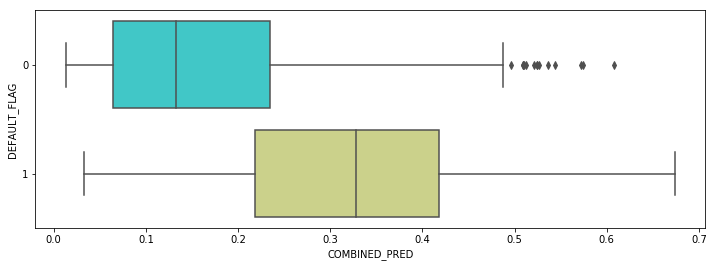

In [13]:
fig = plt.figure(figsize=(12,4))
print(sns.boxplot(x="COMBINED_PRED", y="DEFAULT_FLAG", data=df_predictions, palette='rainbow', orient='h'))

### Feature importance

2 model sonucunda çıkan feature importance'larını birleştirek bizim için en önemli ayraç olan sütunları çıkarıyorum.

In [14]:
feature_importances_lgbm.columns = ['feature', 'importance_lgbm']
feature_importances_xgb.columns = ['feature', 'importance_xgb']

lgbm_oran = feature_importances_lgbm['importance_lgbm'].sum()
xgb_oran = feature_importances_xgb['importance_xgb'].sum()

feature_importances = pd.merge(feature_importances_lgbm,feature_importances_xgb,how='inner',on='feature')
feature_importances['combined_importance'] = feature_importances['importance_lgbm']*xgb_oran + feature_importances['importance_xgb']*lgbm_oran
feature_importances.sort_values(by='combined_importance', inplace=True, ascending=False)
feature_importances.head(10)

,feature,importance_lgbm,importance_xgb,combined_importance
0,MAX_REDCNT_INT_RT_CSHLOAN12,90,0.019231,206.442325
2,AVG_NUMBER_OF_BANK12,63,0.019231,179.442322
4,TL_TOTAL_CASH_RSK_DNM_FRK12,59,0.019231,175.442321
5,STD_NUMBER_OF_BANK_12,58,0.019231,174.442321
11,_MAX_TTL_ACCRD_INT_AMT6_ORAN,42,0.019231,158.442319
1,_MAX_NUMBER_OF_BANK12_ORAN,72,0.011834,143.656816
9,MAX_TTL_LIMIT_UTILIZATION12,43,0.014793,132.571012
194,MAX_ACCRD_INT_RT_CSHLN3,11,0.017751,118.485208
31,AVG_CASH_LIMIT_TL_UTIL12,29,0.013314,109.613910
7,_FR_MAX_TTL_RSK12,45,0.010355,107.699709


### Sonuçların çıkılması

Sonuçlar df_sonuc adlı dataframe'e aktarılarak csv olarak çıktısı alınıyor.

In [20]:
df_sonuc = df_predictions[['PRIMARY_KEY','COMBINED_PRED']]
df_sonuc.columns = ['PRIMARY_KEY', 'SKOR']
df_sonuc['SKOR'] = df_sonuc['SKOR']*1000
print(df_sonuc.head())

df_sonuc.to_csv('Sertac_Ozker_INGDatathonData2018.csv', index=False, sep=';')

       PRIMARY_KEY        SKOR
16412        27939  277.318437
27866        47102  109.801404
9155         15850   58.344389
8114         14047   36.269489
2122          3621  178.661180


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Teşekkür ederim